<font size ='18'> **Forest Fires Prediction** 

Programming Language: R 3.5.1 in Jupyter Notebook

R Libraries used:
- carets
- cowplot
- fastDummies
- forecast
- ggplot2
- GGally
- knitr
- leaps
- randomForest
- reshape

# Table of Contents

* [Introduction](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development](#sec_3)
* [Model Comparison](#sec_4)
* [Variable Identification and Explanation](#sec_5)
* [Conclusion](#sec_6)
* [References](#sec_7)

# Introduction <a class="anchor" id="sec_1"></a>

This work explores different approaches to **predict the burnt area** of bushfires using meteorological data as input. The main problem to address here is how accurate can one predict the burnt area of a bushfire for the given meteorological conditions, and explain the findings of our model. This means that here, I will perform a predictive and descriptive task.

I start with some exploratory analysis in order to gain some relevant insights about the variables of the data through some plots to understand their behavior better. 

Then some models will focus on the insights found in the previous section. Two main approaches will be used, first a linear approach with some tuning in several parameters in order to obtain a better fit, and then a non-linear approach will be evaluated using random forest. 

A feature selection section aims to find the subset of relevant attributes for the prediction task, and finally a comparison between the models and conclusion will finish the notebook.

We will start loading the dataset for the forest fires and having an initial look at the content by checking the first rows and the structure of the data.

In [3]:
fires.data <- read.csv('forestfires.csv')
head(fires.data)
str(fires.data)
# checking for na
sum(is.na(fires.data))

X Y month day FFMC DMC  DC    ISI  temp RH wind rain area
1 7 5 mar   fri 86.2 26.2  94.3  5.1  8.2 51 6.7  0.0  0   
2 7 4 oct   tue 90.6 35.4 669.1  6.7 18.0 33 0.9  0.0  0   
3 7 4 oct   sat 90.6 43.7 686.9  6.7 14.6 33 1.3  0.0  0   
4 8 6 mar   fri 91.7 33.3  77.5  9.0  8.3 97 4.0  0.2  0   
5 8 6 mar   sun 89.3 51.3 102.2  9.6 11.4 99 1.8  0.0  0   
6 8 6 aug   sun 92.3 85.3 488.0 14.7 22.2 29 5.4  0.0  0

'data.frame':	517 obs. of  13 variables:
 $ X    : int  7 7 7 8 8 8 8 8 8 7 ...
 $ Y    : int  5 4 4 6 6 6 6 6 6 5 ...
 $ month: Factor w/ 12 levels "apr","aug","dec",..: 8 11 11 8 8 2 2 2 12 12 ...
 $ day  : Factor w/ 7 levels "fri","mon","sat",..: 1 6 3 1 4 4 2 2 6 3 ...
 $ FFMC : num  86.2 90.6 90.6 91.7 89.3 92.3 92.3 91.5 91 92.5 ...
 $ DMC  : num  26.2 35.4 43.7 33.3 51.3 ...
 $ DC   : num  94.3 669.1 686.9 77.5 102.2 ...
 $ ISI  : num  5.1 6.7 6.7 9 9.6 14.7 8.5 10.7 7 7.1 ...
 $ temp : num  8.2 18 14.6 8.3 11.4 22.2 24.1 8 13.1 22.8 ...
 $ RH   : int  51 33 33 97 99 29 27 86 63 40 ...
 $ wind : num  6.7 0.9 1.3 4 1.8 5.4 3.1 2.2 5.4 4 ...
 $ rain : num  0 0 0 0.2 0 0 0 0 0 0 ...
 $ area : num  0 0 0 0 0 0 0 0 0 0 ...


[1] 0

In [4]:
summary(fires.data)

       X               Y           month      day          FFMC      
 Min.   :1.000   Min.   :2.0   aug    :184   fri:85   Min.   :18.70  
 1st Qu.:3.000   1st Qu.:4.0   sep    :172   mon:74   1st Qu.:90.20  
 Median :4.000   Median :4.0   mar    : 54   sat:84   Median :91.60  
 Mean   :4.669   Mean   :4.3   jul    : 32   sun:95   Mean   :90.64  
 3rd Qu.:7.000   3rd Qu.:5.0   feb    : 20   thu:61   3rd Qu.:92.90  
 Max.   :9.000   Max.   :9.0   jun    : 17   tue:64   Max.   :96.20  
                               (Other): 38   wed:54                  
      DMC              DC             ISI              temp      
 Min.   :  1.1   Min.   :  7.9   Min.   : 0.000   Min.   : 2.20  
 1st Qu.: 68.6   1st Qu.:437.7   1st Qu.: 6.500   1st Qu.:15.50  
 Median :108.3   Median :664.2   Median : 8.400   Median :19.30  
 Mean   :110.9   Mean   :547.9   Mean   : 9.022   Mean   :18.89  
 3rd Qu.:142.4   3rd Qu.:713.9   3rd Qu.:10.800   3rd Qu.:22.80  
 Max.   :291.3   Max.   :860.6   Max.   :56.

As seen above, we have a dataset with 13 variables, three of them int-numeric (X,Y and RH), two factor variables (month and day) and the rest are numerical. We check for anomalies like negative values for the variables, but it can be seen that the min is 0 for them so there are no anomalies of this kind. We will try to predict the burnt area later, so the last variable corresponds to our target. Now we will continue with the exploratory task.

# Data Exploration<a class="anchor" id="sec_2"></a>

Let's start having a look at the correlation between different variables and the distribution of them with the use of the `ggpairs` function. In the graph below, the images for coordinates, month and day have been removed. For some of the variables, it can be seen that there are some higher correlation like the case of DC and DMC or RH with temp. However, we can't see a big correlation at a first glance from individual variables with the target (area).
In a later stage, during the model fitting process, we will use some of the insights of the graph below, as we can see some correlation among some of the variables.

In [5]:
## function to create a corr matrix with distributions
corgr_fn <- function(data, mapping, method="p", use="pairwise", ...){
      # get data
      x <- eval_data_col(data, mapping$x)
      y <- eval_data_col(data, mapping$y)

      # calculate correlation
      corr <- cor(x, y, method=method, use=use)

      # calculate colour based on correlation value
      # Correlation of minus one to blue, zero to white, and one to red
      colFn <- colorRampPalette(c("blue", "white", "red"), interpolate ='spline')
      fill <- colFn(100)[findInterval(corr, seq(-1, 1, length=100))]

      ggally_cor(data = data, mapping = mapping, ...) + 
        theme_void() +
        theme(panel.background = element_rect(fill=fill))
    }

## Scatter Plot Matrix (SPLOM)

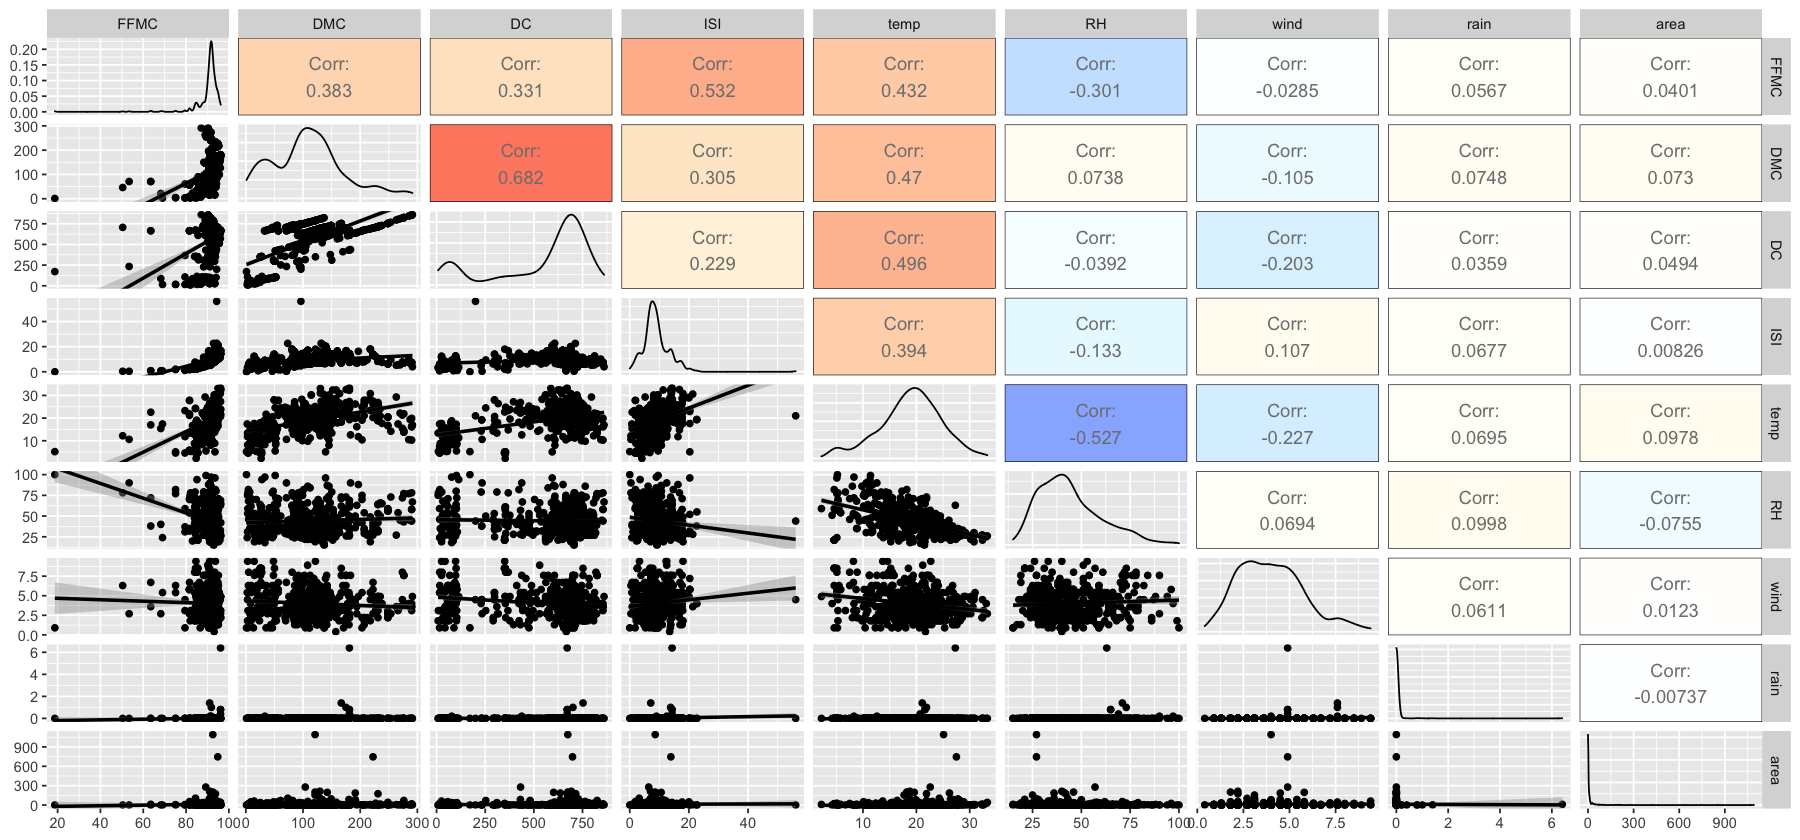

In [7]:
# install.packages('GGally')
library(GGally)
options(repr.plot.width=15)
plt<-ggpairs(fires.data[,5:ncol(fires.data)],upper = list(continuous = corgr_fn),lower = list(continuous = "smooth"))
suppressMessages(print(plt))

The graph above intends to give the big picture of the dataset. Some predictors present issues in order to do linear regression. First, we can observe that the `area` parameter (our target) is highly skewed to the right, and it doesn't seem to present a big correlation with any of the predictors, as the higher value is around 0.10 for the `ISI` parameter.

We can also observe some signs of collinearity between some of our predictors, like the case of `DC` and `DMC`, `ISI` and `FFMC`, `temp` and `DC`, or `temp` and `RH` as they seem related with each other. This can make challenging to understand the different effects that each of these variables have on our target. A good method to detect collinearity is by having a look at the graph above for high values, however in order to detect possible cases of multicollinearity we can have implement the variance inflation factor (a VIF above 10 can be a sign of multicollinearity).

Finally, some of the other variables are skewed and the scales are very different, so performing some normalization and transformation will improve the fitting of models. Variables like `rain`, `ISI` and `area` are very skewed to the right, while `FFMC` and `DC` are skewed to the left.

## Check the VIF for multicollinearity

In [9]:
# install.packages('olsrr')
library(olsrr)

lmod <- lm(area~.-day,data=fires.data)
ols_vif_tol(lmod)

Variables Tolerance  VIF      
1  X         0.66132194  1.512123
2  Y         0.66221403  1.510086
3  monthaug  0.02395167 41.750748
4  monthdec  0.34177603  2.925893
5  monthfeb  0.31796787  3.144972
6  monthjan  0.64639491  1.547042
7  monthjul  0.12620148  7.923837
8  monthjun  0.27078817  3.692923
9  monthmar  0.15561544  6.426098
10 monthmay  0.79837085  1.252551
11 monthnov  0.88902063  1.124833
12 monthoct  0.13729225  7.283732
13 monthsep  0.01967523 50.825337
14 FFMC      0.44157885  2.264601
15 DMC       0.25728904  3.886679
16 DC        0.03749446 26.670604
17 ISI       0.56415393  1.772566
18 temp      0.22799551  4.386051
19 RH        0.37674425  2.654321
20 wind      0.79906520  1.251462
21 rain      0.93631038  1.068022

The above table already gives as an idea of some problematic variables, perhaps `DC` is not very relevant as it presents a high score for VIF. (categorical variables like the months should be further analyzed as a high VIF score for just one of them is not enough to conclude collinearity)

## Coordinates views of area burnt, temperature and RH per month
In the graph below, we can observe the coordinates and information about the burnt area for each month, where the monts of July, August, and September, show the bigger burnt areas for the dataset. In the second graph we can observe that July, August and September again, present the higher temperatures which could have been expected with respect to what can affect the burnt area in the bush fires.

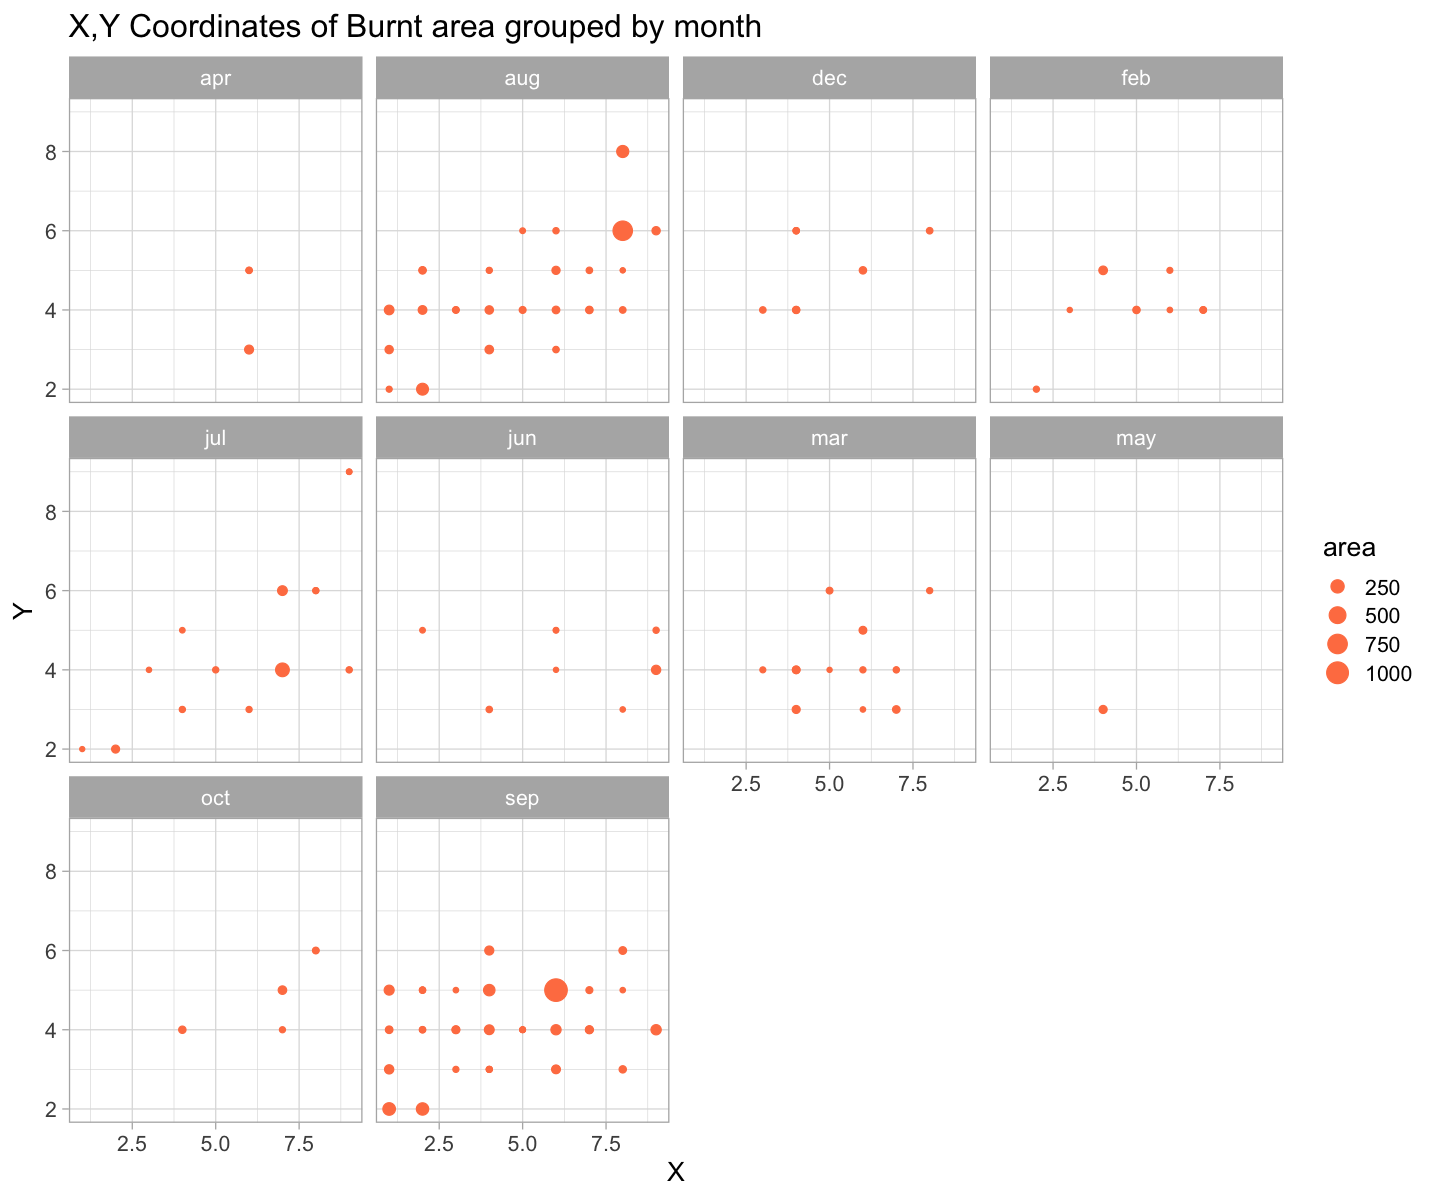

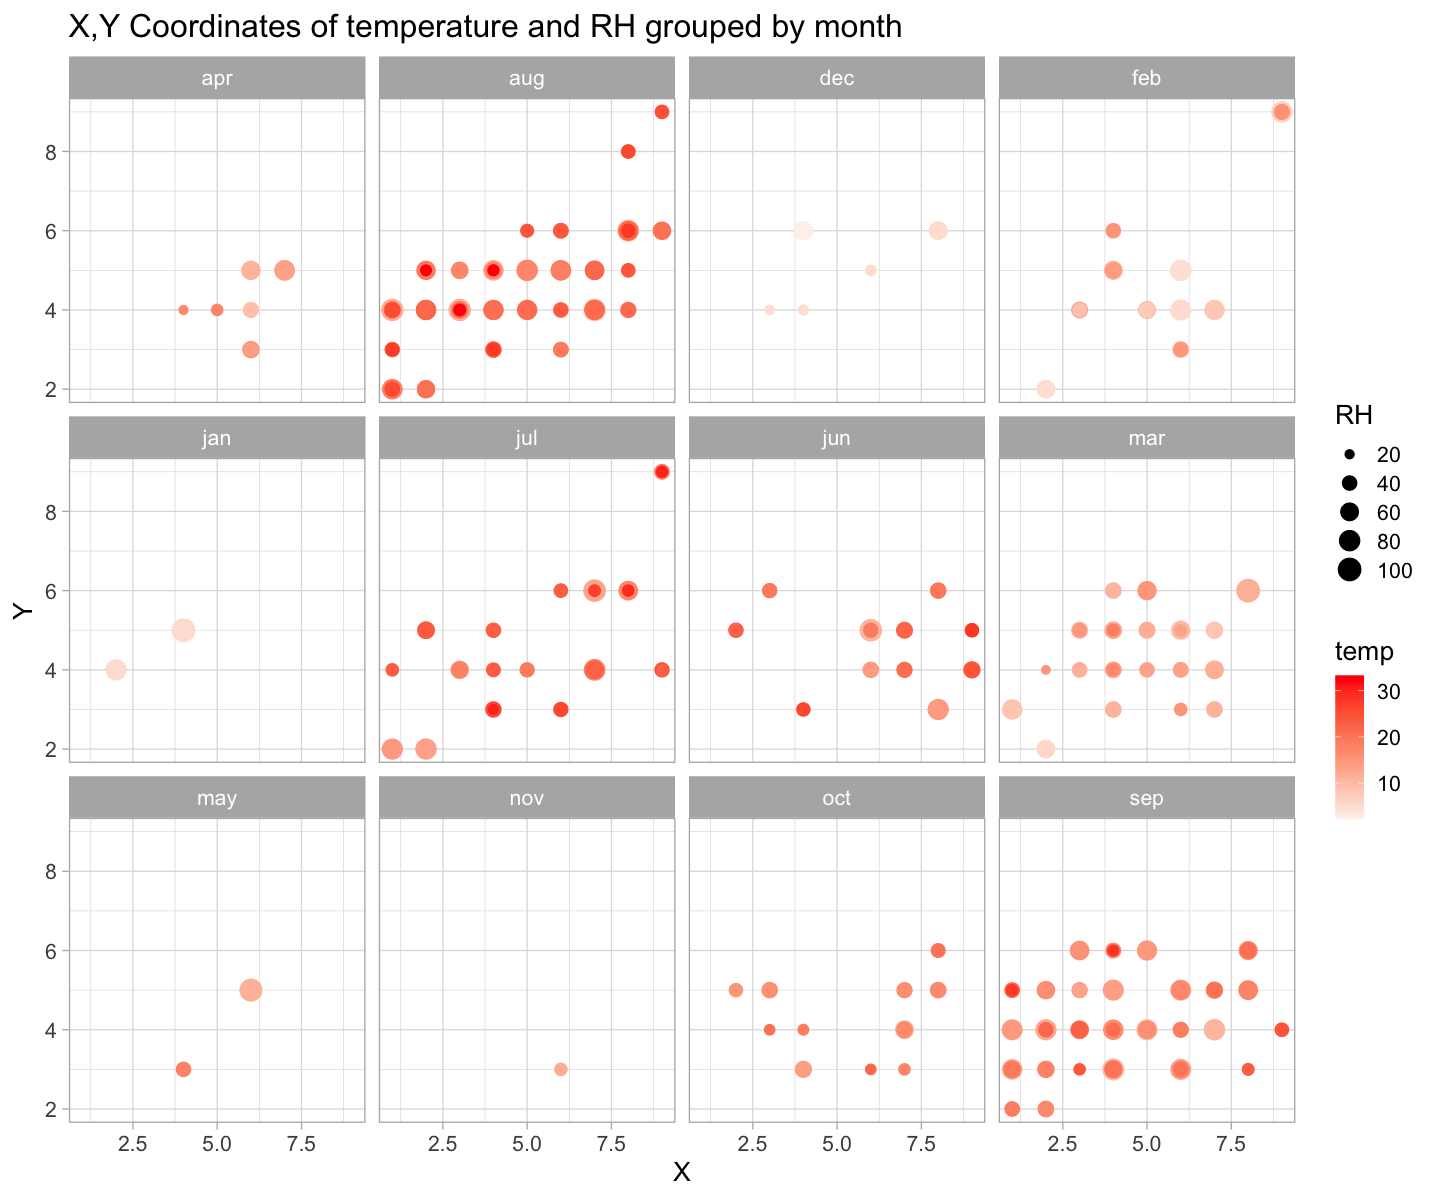

In [10]:
library(reshape)
library(ggplot2)
options(repr.plot.width=12, repr.plot.height=10)

ggplot(fires.data[fires.data$area>0,],aes(X,Y))+geom_point(aes(size=area),color='coral')+facet_wrap(~month)+
        ggtitle("X,Y Coordinates of Burnt area grouped by month")+ theme_light(base_size=16)

ggplot(fires.data,aes(X,Y))+geom_point(aes(color=temp,size=RH))+facet_wrap(~month)+scale_color_gradient2(high="red")+
        ggtitle("X,Y Coordinates of temperature and RH grouped by month")+ theme_light(base_size=16)

The relation described in these two graphs is very interesting as it suggests that the variable `temp` has a close relationship with `area`, our target variable, because it is observed that for the same months with bigger burnt area, the temperature was higher and viceversa. However, the `RH` parameter is more challenging as it is not showing a clear pattern to link with `area`.

## Closer look to some variables identified in the SPLOM above
The graphs below show that some of the areas associated with different parameters are apparently very big and we may have potential outliers or high leverage points. In order to verify this we will check at a later stage for residuals and influenceplot.

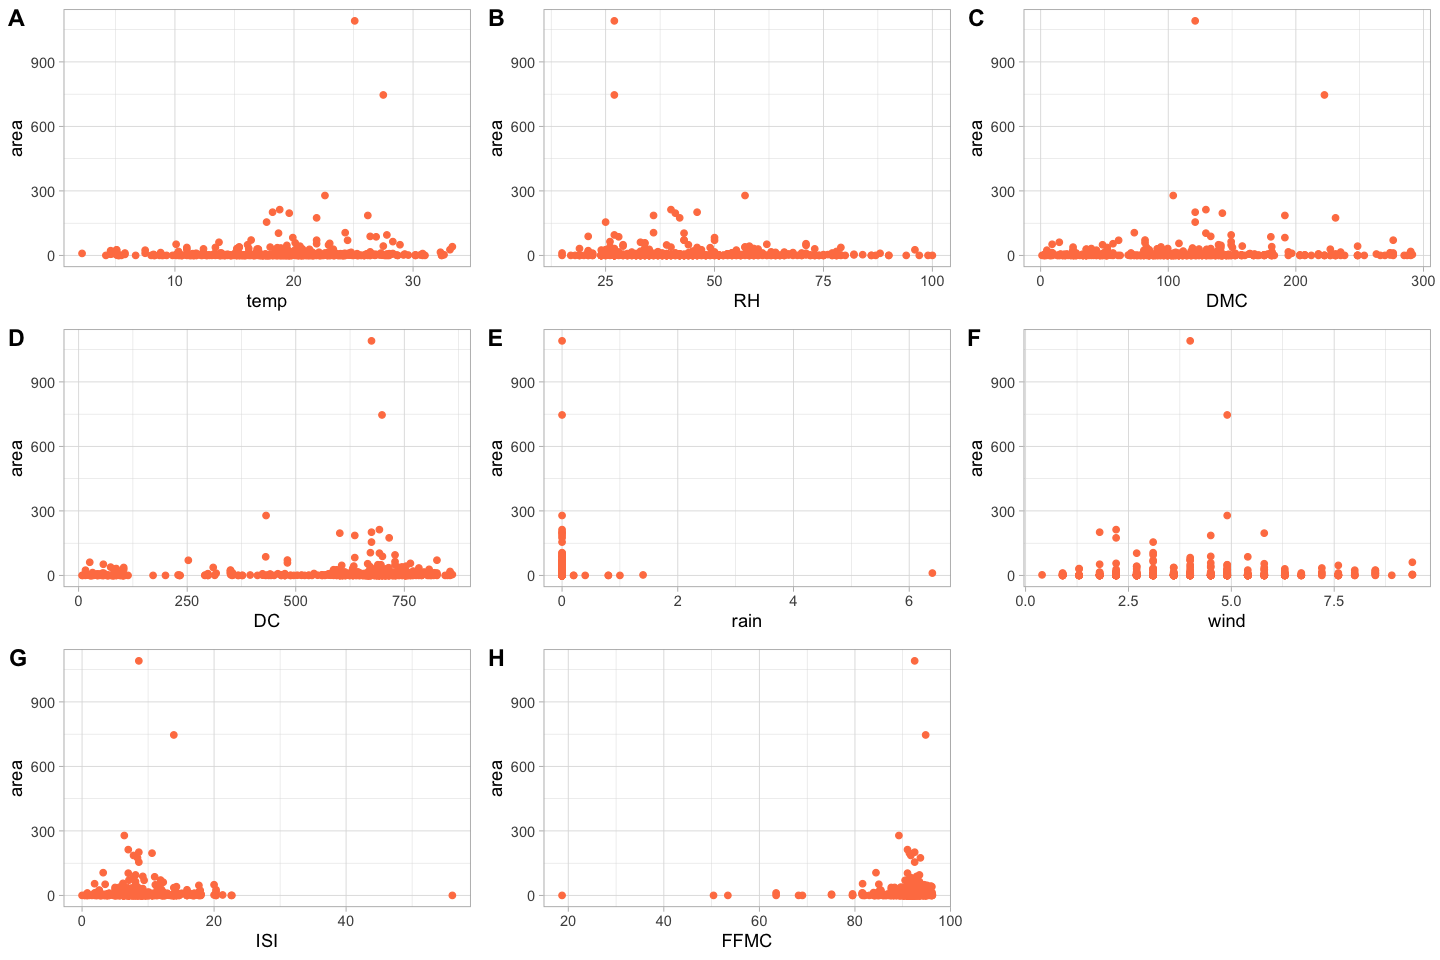

In [12]:
options(repr.plot.width=12, repr.plot.height=8)

# install.packages('cowplot')
library(cowplot)
pl1<-ggplot(fires.data,aes(temp,area))+geom_point(color='coral')+theme_light()
pl2<-ggplot(fires.data,aes(RH,area))+geom_point(color='coral')+theme_light()
pl3<-ggplot(fires.data,aes(DMC,area))+geom_point(color='coral')+theme_light()
pl4<-ggplot(fires.data,aes(DC,area))+geom_point(color='coral')+theme_light()
pl5<-ggplot(fires.data,aes(rain,area))+geom_point(color='coral')+theme_light()
pl6<-ggplot(fires.data,aes(wind,area))+geom_point(color='coral')+theme_light()
pl7<-ggplot(fires.data,aes(ISI,area))+geom_point(color='coral')+theme_light()
pl8<-ggplot(fires.data,aes(FFMC,area))+geom_point(color='coral')+theme_light()
plot_grid(pl1,pl2,pl3,pl4,pl5,pl6,pl7,pl8, labels = "AUTO")

## Boxplots to check some of the predictors
In this section we observe the boxplots of the features. However, the values are very different, and it seems that in a subsequent state, we will require some data scaling.

In [13]:
# Function boxplot
library(reshape)
my_bxplt <- function(df,cols,title){
    m1 <- melt(as.data.frame(df[,cols]))
    ggplot(m1,aes(x=variable,y=value))+geom_boxplot(fill='cadetblue',alpha=0.7,outlier.colour='coral')+scale_x_discrete()+
          ggtitle(title)+theme_light(base_size=16)
    }

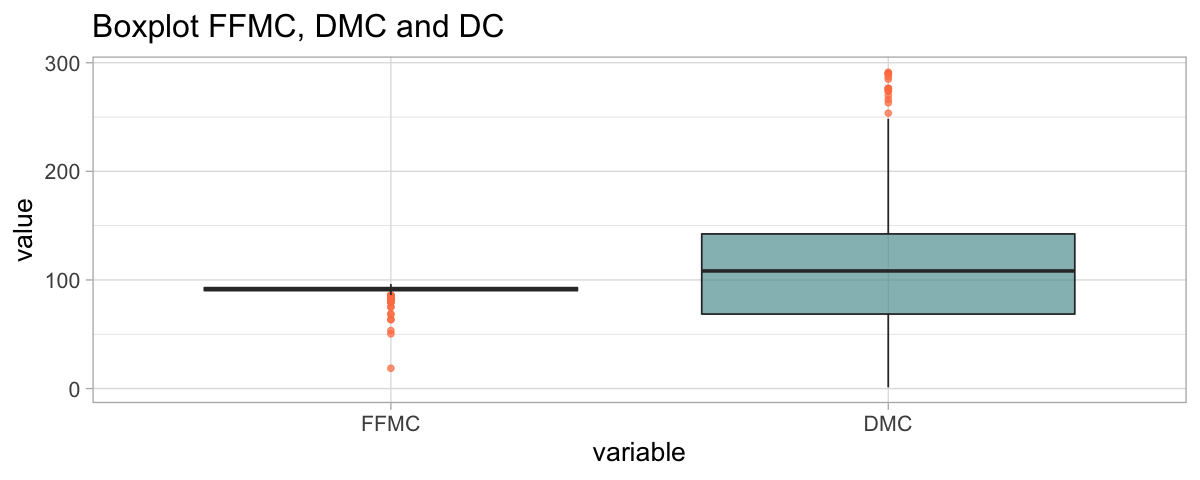

In [14]:
options(repr.plot.width=10, repr.plot.height=4)
suppressMessages(my_bxplt(fires.data,5:6,"Boxplot FFMC, DMC and DC"))

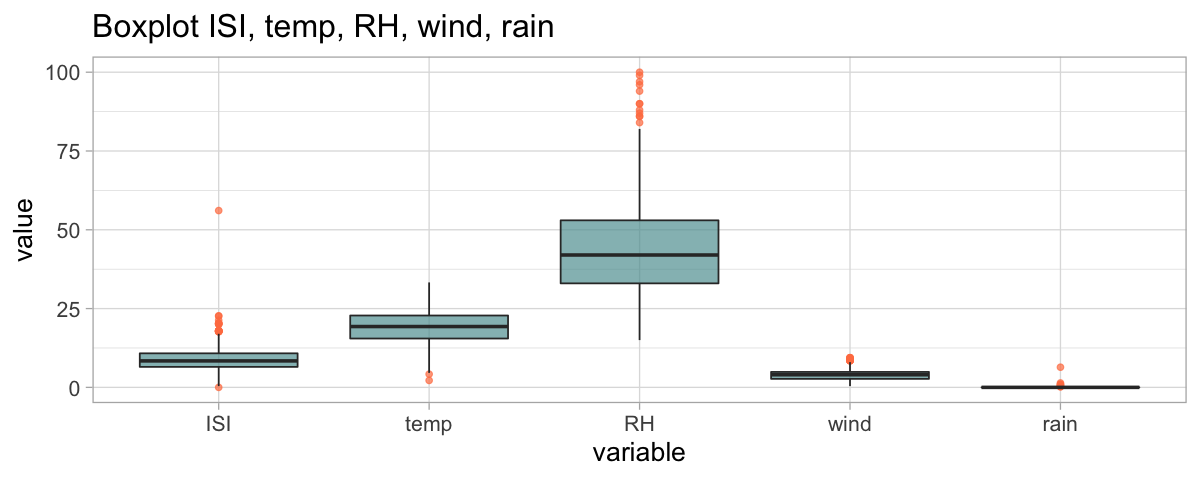

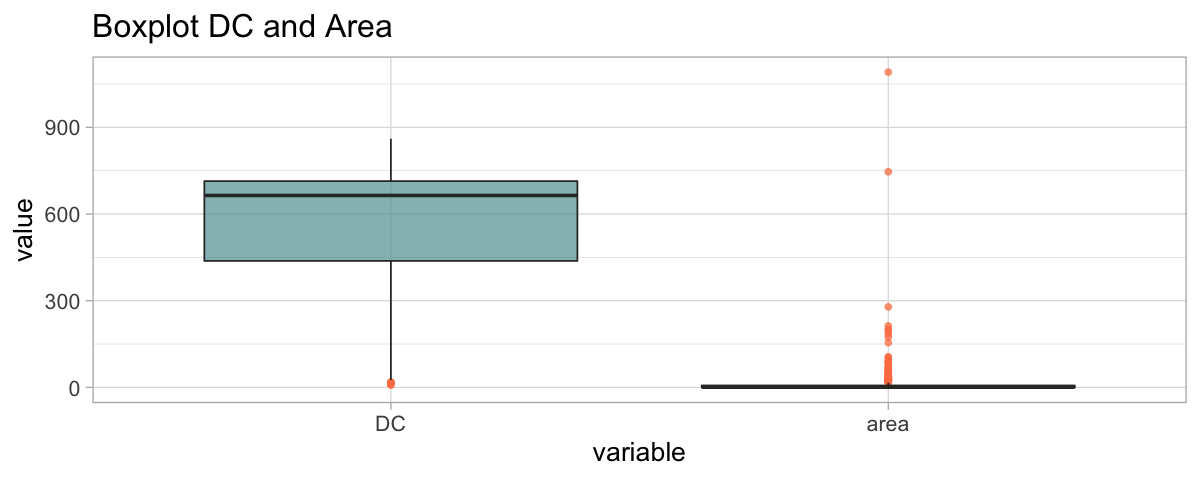

In [15]:
suppressMessages(my_bxplt(fires.data,8:12,"Boxplot ISI, temp, RH, wind, rain"))
suppressMessages(my_bxplt(fires.data,c(7,13),"Boxplot DC and Area"))

The boxplots show that for almost all variables we can find potential outliers, so we should be aware of possible high leverage observations.  
This exploration also helps to understand why the dataset is challenging in order to perform a prediction task, as it contains a lot of data with zero values for the target (when there are no bushfires) therefore, the `area` column contains a huge variability.

## Burnt area vs temp and wind

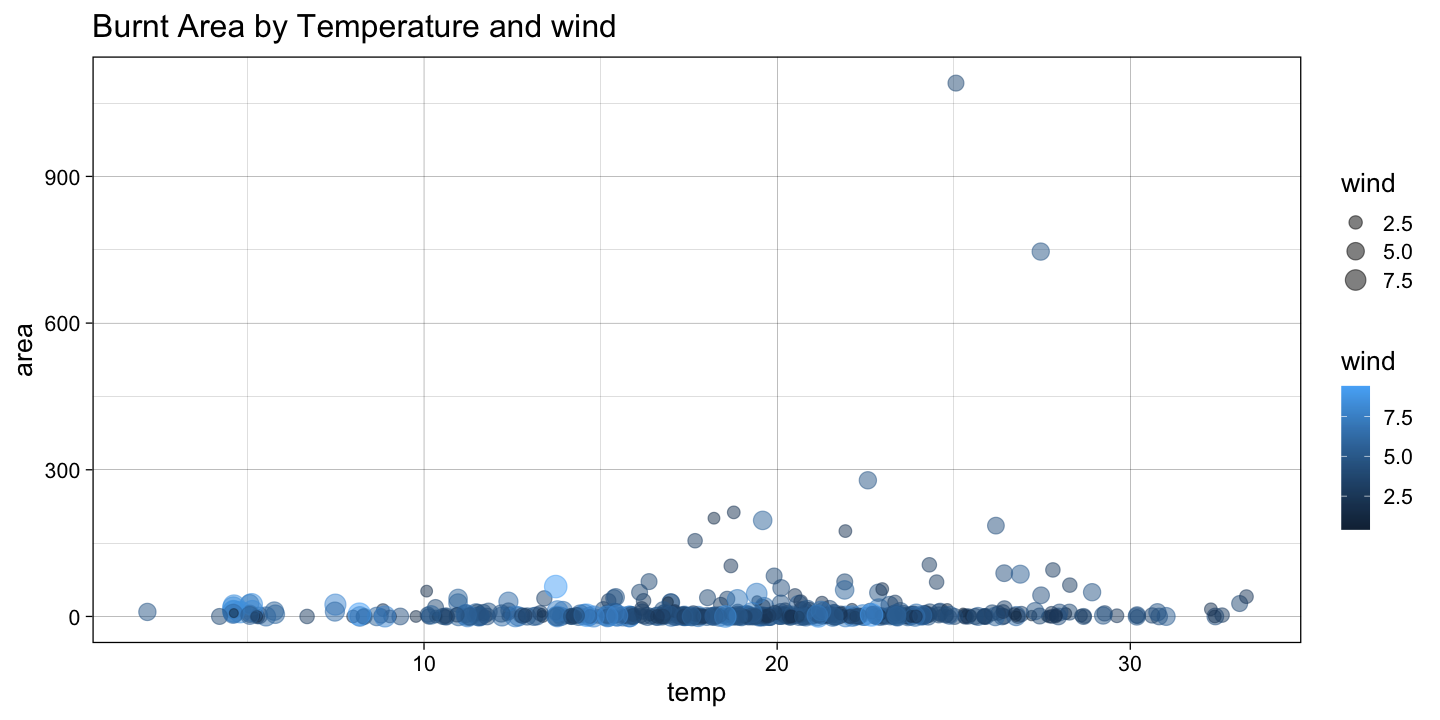

In [16]:
options(repr.plot.width=12, repr.plot.height=6)
ggplot(aes(x = temp, y = area), data = fires.data) + 
    geom_point(aes(color=wind, size=wind),alpha=1/2, position = 'jitter') +
    ggtitle('Burnt Area by Temperature and wind')+theme_linedraw(base_size = 16)

In this graph, the variability in the `area` variable show that is very difficult to establish a model as most of the values are 0's but several of them represent burnt areas of above 100 with one over 1000 hectares.

## Re-formatting Data
In the following step, the dataset will be re-formatted to include the coordinates as factor variables and convert the columns `X`, `Y`, and `month` into dummy columns in order to predict later using them in the model.

In [17]:
# Treat the coordinates as factor variables
fires.data$X <- as.factor(fires.data$X)
fires.data$Y <- as.factor(fires.data$Y)

# install.packages(c("fastDummies","knitr"))
fires.data2 <- fastDummies::dummy_cols(fires.data, select_columns = "month")
fires.data2 <- fastDummies::dummy_cols(fires.data2, select_columns = "X")
fires.data2 <- fastDummies::dummy_cols(fires.data2, select_columns = "Y")
fires.data2 <- fires.data2[,-match(c('month','X','Y'),names(fires.data2))]
# fires.data2 <- fires.data2[,-match(c('month'),names(fires.data2))]
head(fires.data2)

day FFMC DMC  DC    ISI  temp RH wind rain area ⋯ X_7 X_8 X_9 Y_2 Y_3 Y_4 Y_5
1 fri 86.2 26.2  94.3  5.1  8.2 51 6.7  0.0  0    ⋯ 1   0   0   0   0   0   1  
2 tue 90.6 35.4 669.1  6.7 18.0 33 0.9  0.0  0    ⋯ 1   0   0   0   0   1   0  
3 sat 90.6 43.7 686.9  6.7 14.6 33 1.3  0.0  0    ⋯ 1   0   0   0   0   1   0  
4 fri 91.7 33.3  77.5  9.0  8.3 97 4.0  0.2  0    ⋯ 0   1   0   0   0   0   0  
5 sun 89.3 51.3 102.2  9.6 11.4 99 1.8  0.0  0    ⋯ 0   1   0   0   0   0   0  
6 sun 92.3 85.3 488.0 14.7 22.2 29 5.4  0.0  0    ⋯ 0   1   0   0   0   0   0  
  Y_6 Y_8 Y_9
1 0   0   0  
2 0   0   0  
3 0   0   0  
4 1   0   0  
5 1   0   0  
6 1   0   0

### Variable Scaling and Transformation
Now we will transform the data as some of the variables present highly skewed distributions and we will also normalize the data.

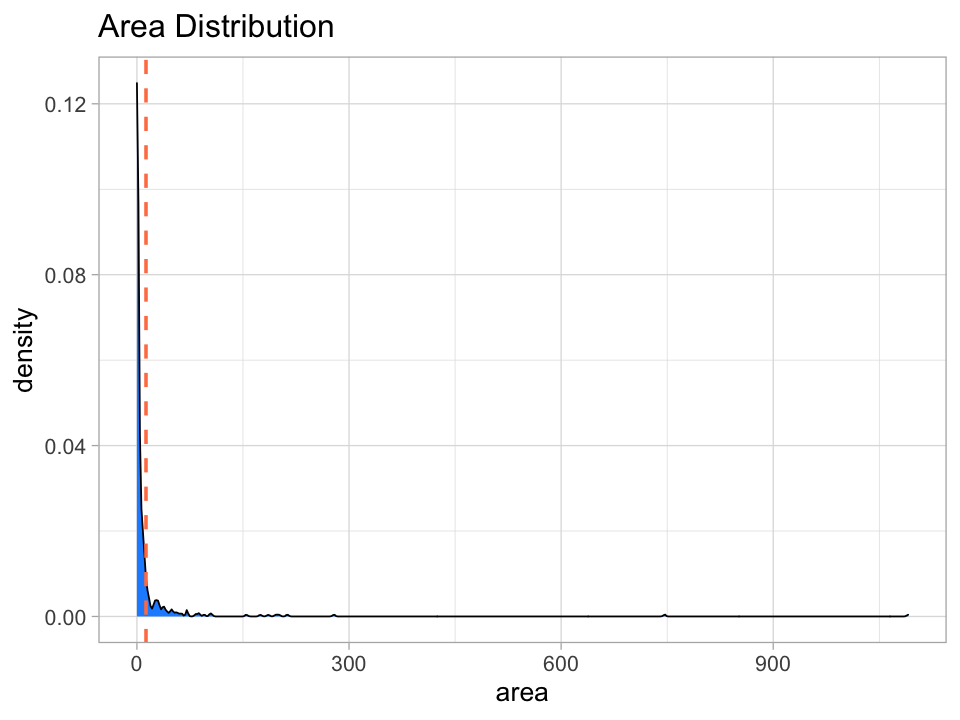

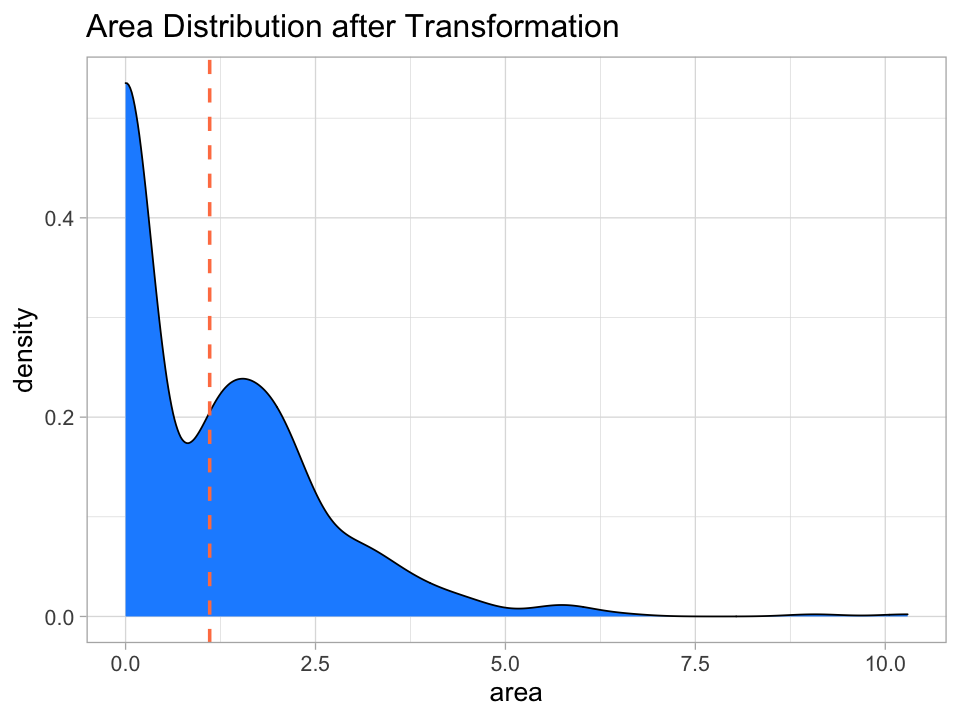

In [18]:
# fires.data <- read.csv('forestfires.csv')
fires.data<-fires.data2

# Transformation
# fires.data$FFMC<-fires.data$FFMC^3
fires.data$DC<-fires.data$DC^(1/3)
fires.data$ISI<-fires.data$ISI^(1/2)
fires.data$rain<-(fires.data$rain)^(1/3)

# Scaling
fires.data$FFMC<-fires.data$FFMC/max(fires.data$FFMC)
fires.data$rain<-fires.data$rain/max(fires.data$rain)
fires.data$DMC<-fires.data$DMC/max(fires.data$DMC)
fires.data$DC<-fires.data$DC/max(fires.data$DC)
fires.data$RH<-fires.data$RH/max(fires.data$RH)
fires.data$wind<-fires.data$wind/max(fires.data$wind)
fires.data$ISI<-fires.data$ISI/max(fires.data$ISI)
fires.data$temp<-fires.data$temp/max(fires.data$temp)

options(repr.plot.width=8, repr.plot.height=6)
ggplot(fires.data, aes(x=area))+geom_density(fill='dodgerblue')+ theme_light(base_size = 16)+ggtitle('Area Distribution')+
        geom_vline(aes(xintercept=mean(area)),color="coral",linetype="dashed", size=1)

# transformation of area
fires.data$area <- (fires.data$area)^(1/3)

ggplot(fires.data, aes(x=area))+geom_density(fill='dodgerblue')+ theme_light(base_size = 16)+ggtitle('Area Distribution after Transformation')+
        geom_vline(aes(xintercept=mean(area)),color="coral",linetype="dashed", size=1)

### Results after transformation
The transformation results can be observed in the following graph.

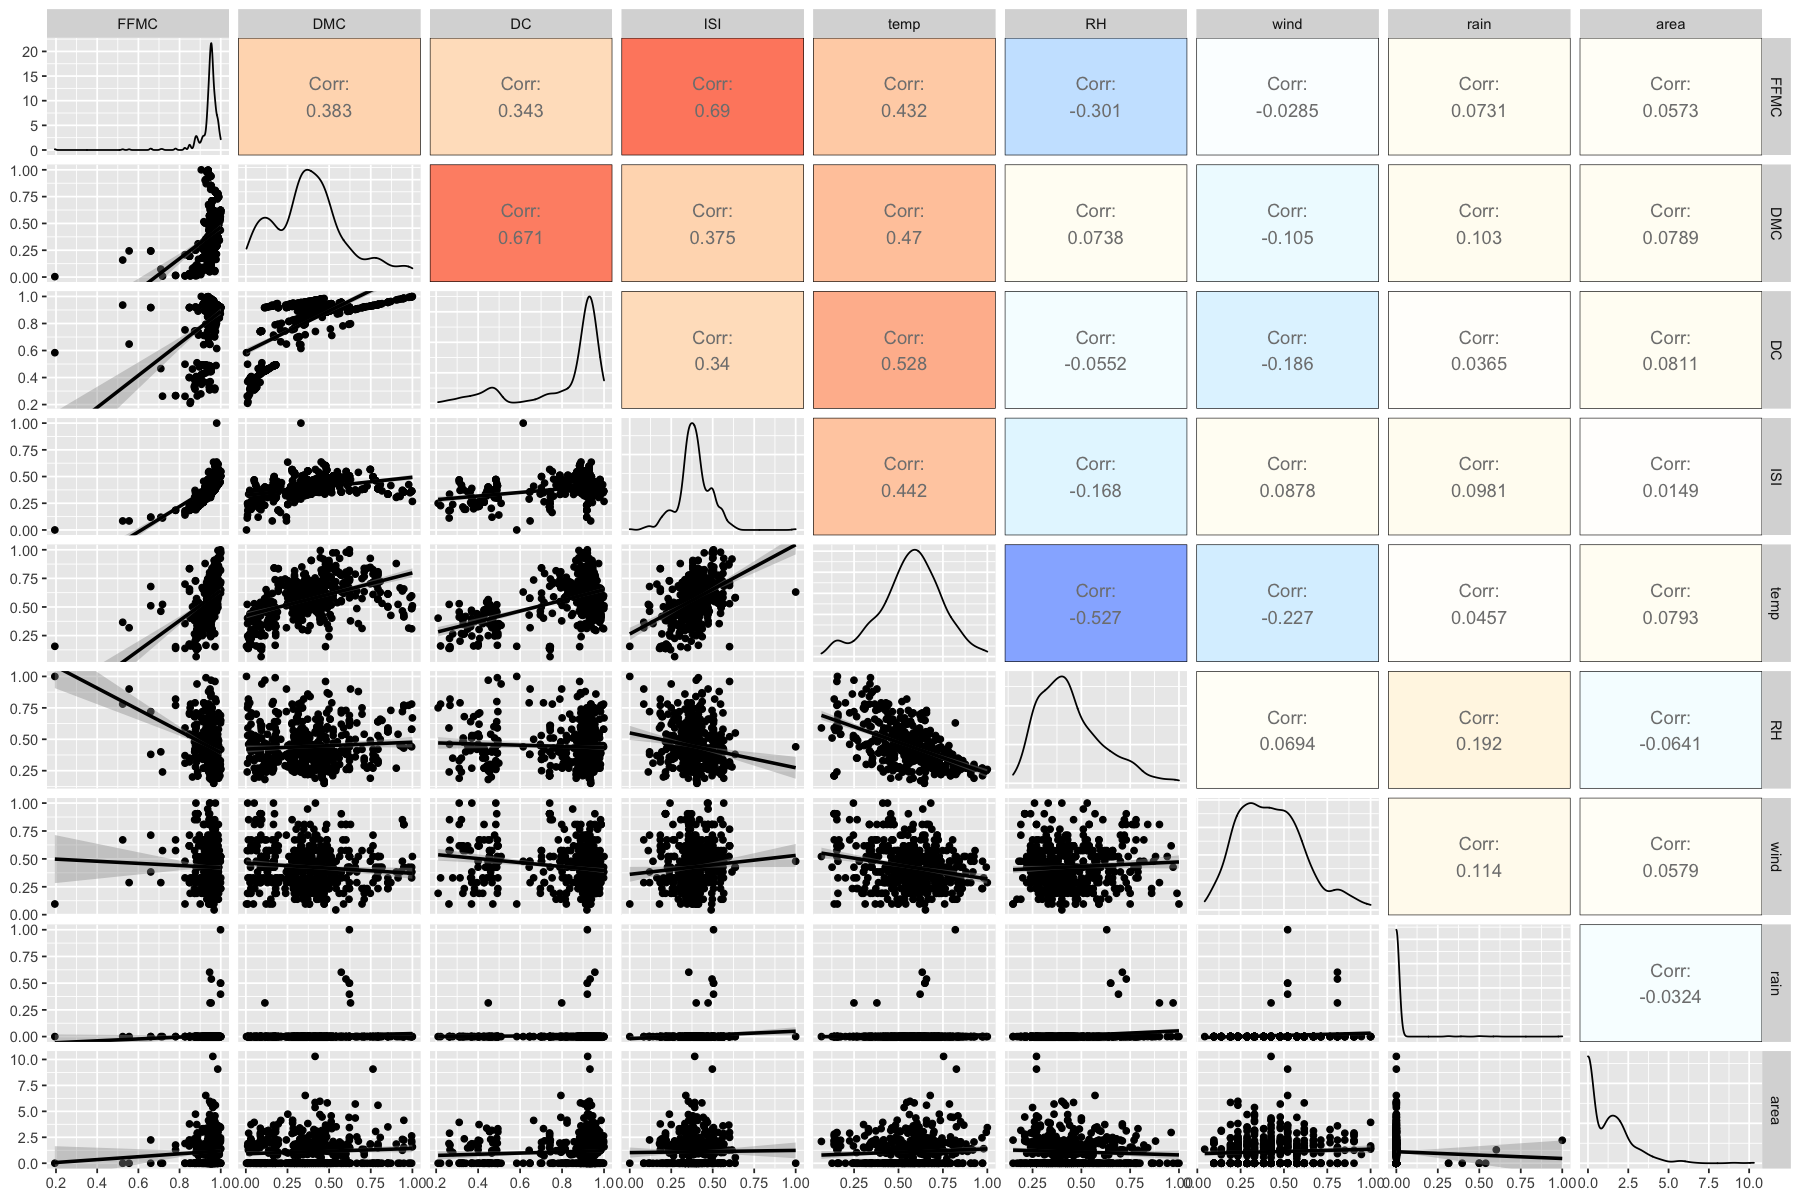

In [19]:
options(repr.plot.width=15, repr.plot.height=10)
plt<-ggpairs(fires.data[,2:10],upper = list(continuous = corgr_fn),lower = list(continuous = "smooth"))
suppressMessages(print(plt))

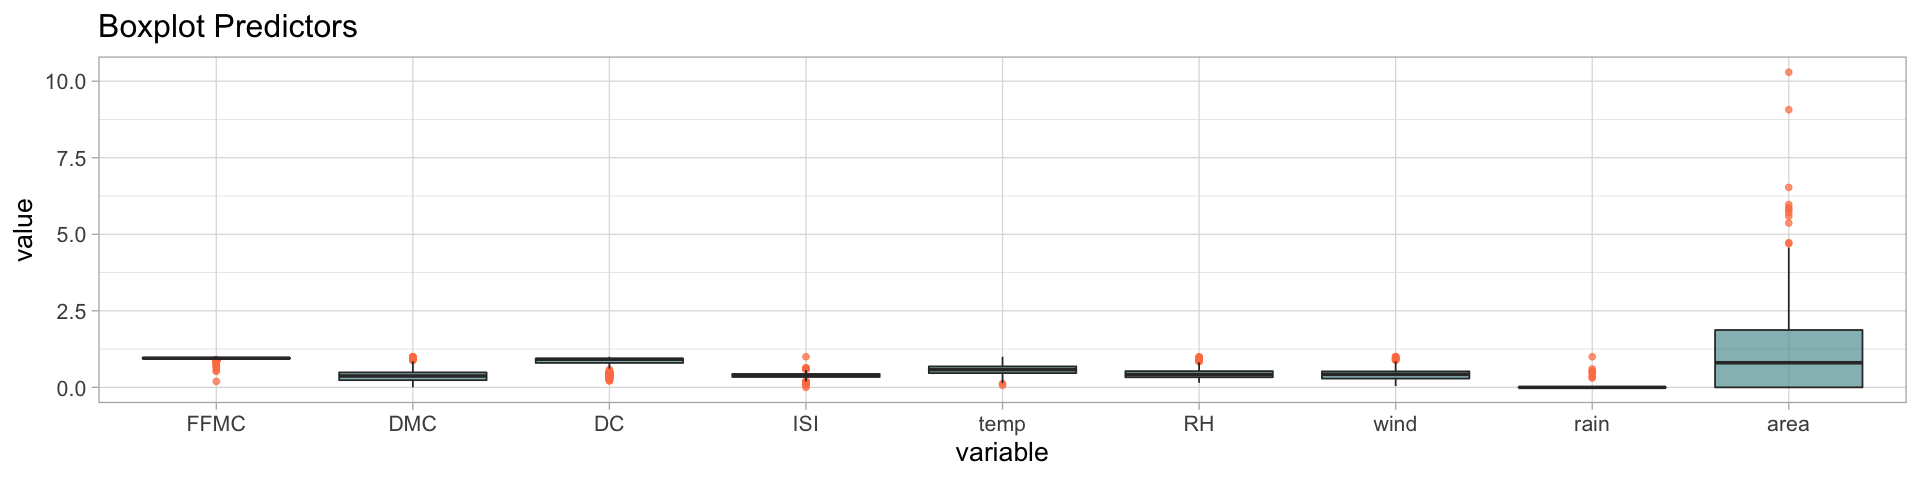

In [20]:
options(repr.plot.width=16, repr.plot.height=4)
suppressMessages(my_bxplt(fires.data,2:10,"Boxplot Predictors"))

## Summary
After exploring the dataset, it can be observed that there is a small correlation between the predictors and the target variable (`area`). However, it could be observed that some categorical variables may provide relevant information, like some particular months of the year in order to predict the target. This makes sense, taking into consideration that the bushfires are expected to intensify during the hot season of the year, which for this particular dataset seems to be hotter for July, August and September.

The collinearity of the variables was also analyzed in an initial stage, finding that the DC variable presents a high VIF score (Variance Inflation Factor), which may affect the interpretability of the model.

Finally, after performing some transformation to the dataset, it could be observed that some variables present a stronger correlation and this can be an insight for including some interacting variables in the model in a posterior phase. 

## Training and testing datasets
We will now split the data in training (80%) and testing. 

In [21]:
set.seed(12345)
smpl_size <- floor(0.8 * nrow(fires.data))

# shuffle data
fires.data2 <- fires.data[sample(1:nrow(fires.data),nrow(fires.data)),]

# create  training and testing sets:
train.index = 1:smpl_size
train.data <- fires.data2[train.index, ] # grab the sample size rows for training
test.data <- fires.data2[-train.index, ] # grab the rows not used for training as testing

dim(train.data) 
dim(test.data)

[1] 413  38

[1] 104  38

# Model Development<a class="anchor" id="sec_3"></a>
The first model will consider a linear approach, with the use of linear regression. In this first approach, we will implement different techniques in order to improve the performance of our model. In the next stage, we will evaluate a non-linear model with the implementation of Random Forest.

## Linear Regression
To implement this model, we should understand what parameters are suitable to be included. We can start performing a multiple linear regression as follows, however, later we will remove some of the predictors as they might not make sense to be included in the model or they may not be statistically significant.

In [22]:
linmod <- lm(area~.-day, data=train.data)
summary(linmod)


Call:
lm(formula = area ~ . - day, data = train.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8868 -0.9775 -0.2924  0.6830  7.2332 

Coefficients: (3 not defined because of singularities)
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.53686    2.91924  -0.184  0.85419    
FFMC         2.19997    2.47417   0.889  0.37447    
DMC          1.03607    0.56211   1.843  0.06608 .  
DC          -1.94927    1.92951  -1.010  0.31303    
ISI         -0.14578    1.11948  -0.130  0.89646    
temp         0.31013    0.81954   0.378  0.70533    
RH          -0.39460    0.69661  -0.566  0.57142    
wind         0.47026    0.39825   1.181  0.23842    
rain        -0.62217    1.05813  -0.588  0.55689    
month_apr   -0.65110    1.20419  -0.541  0.58904    
month_aug   -0.45179    0.21420  -2.109  0.03558 *  
month_dec    0.92696    0.76216   1.216  0.22466    
month_feb   -0.34030    1.14601  -0.297  0.76667    
month_jan   -2.16690    1.90685  -1.136  0.25652    


As expected, a linear model including most of the variables presents very poor performance with just `month_aug` and some of the coordinate varaibles having p-values below 5%. However, the F-statistic's p-value is less than 1% (0.004), which gives evidence to reject $H_0$ (i.e. we expect that not all the coefficients are 0, therefore, the model is useful). Also, the adjusted R-squared is just above 6% (we will focus on the Adjusted R-squared rather than on R-squared which is higher with 14% but it doesn't penalize the extra features that are not adding much information to the model). We will have a look at the outliers and influencial points to have an idea if this is currently an issue of the model:
### Outliers

Warning message:
“not plotting observations with leverage one:
  152, 216, 304”


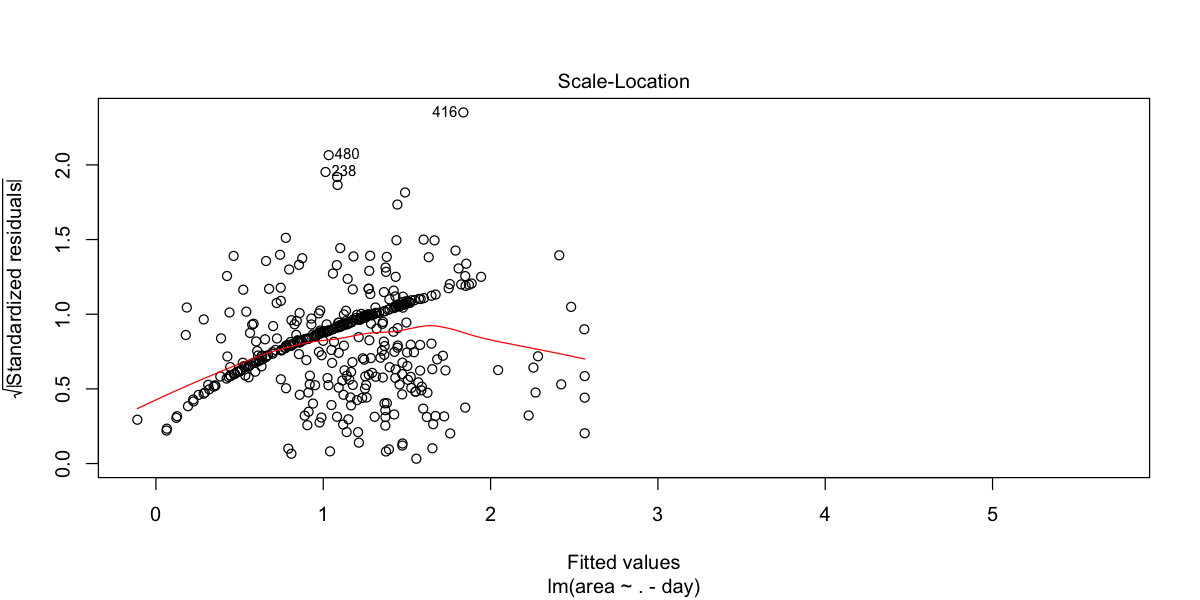

In [23]:
options(repr.plot.width=10, repr.plot.height=5)
plot(linmod, which = 3)

As expected, we see some observations that are looking as potential outliers. Now we will implement the `outlierTest()` to check this. (**NOTE**: The residuals plot is showing that there is some pattern in the residuals, therefore the linear model described is not appropriate and will be modified later, however, the correspondent analysis of outliers and other aspects of the model is included below to illustrate the different tools that can be modified with this approach)

In [25]:
#install.packages('car')
library(car)
outlierTest(linmod, cutoff=0.05, digits = 1)

    rstudent unadjusted p-value Bonferroni p
416 5.758087         1.7629e-08   7.2281e-06
480 4.365547         1.6389e-05   6.7196e-03

We will now look for influential points using the `influencePlot()` function.

StudRes  Hat        CookD     
416 5.758087 0.03853387 0.03602626
480 4.365547 0.06668874 0.03823048
500 1.940001 0.54097112 0.12951015
105      NaN 1.00000000        NaN
472 1.566501 0.52831986 0.08053210
421      NaN 1.00000000        NaN

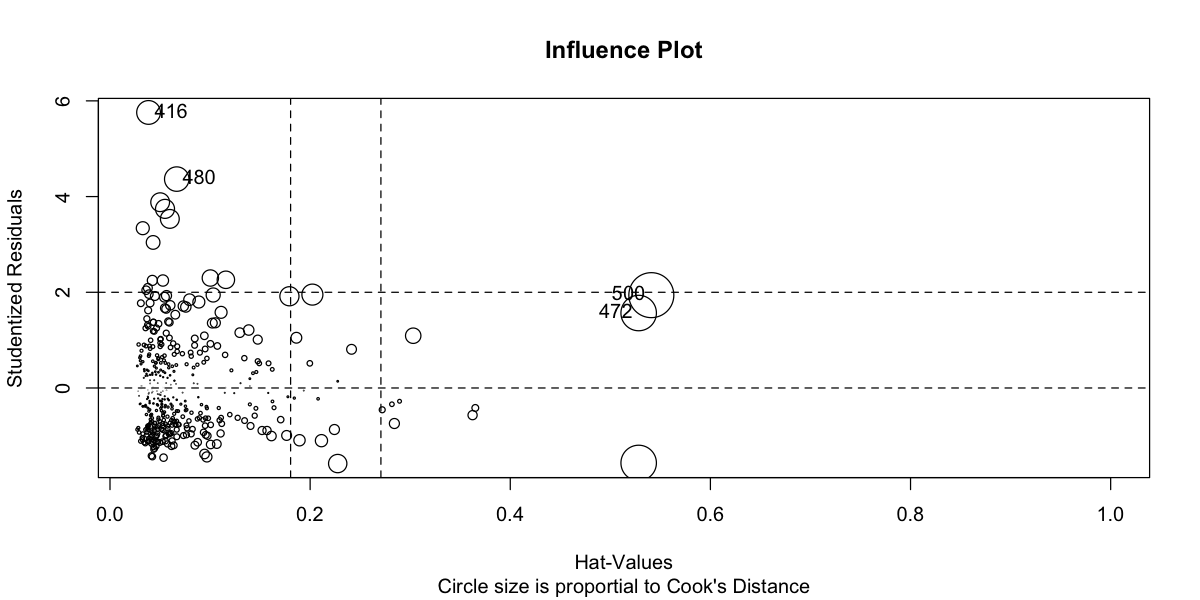

In [26]:
infl_points <- suppressWarnings(influencePlot(linmod, scale=5, id.method="noteworthy", main="Influence Plot", sub="Circle size is proportial to Cook's Distance" ))
infl_points

In the above graph we observe that the datapoints considered as outliers are also influence points, and in addition we also find two additional influence points that will be removed from the model in order to improve the generalization of the model
#### Function to remove influence points

In [27]:
remove_infl <- function(infl_plot,df){
    infl_points <- row.names(infl_plot)
    # return the index of the infl_points in the row.names of our train.data and assign it as the infl_points
    infl_points <- which(row.names(df)%in%infl_points)
    return (df <- df[-infl_points, ])
} 

In [28]:
train.data2 <- remove_infl(infl_points,train.data)
dim(train.data2)

[1] 407  38

### Fitting the model without the influence points

In [29]:
clean_infl_points <- function(lmod,df){
    df.len <- nrow(df)
    influent_points <- suppressWarnings(influencePlot(lmod, scale=5, id.method="noteworthy", main="Influence Plot", sub="Circle size is proportial to Cook's Distance" ))
    ifelse(length(infl_points)>0,df<-remove_infl(influent_points,df),print('No more infl. points'))
    cat('Removed infl. points:',df.len-nrow(df))
    return(df)
}

In [30]:
linmod <- lm(area~.-day, data=train.data2)
summary(linmod)$adj.r.squared
summary(linmod)$fstatistic

[1] 0.05172642

value      numdf      dendf 
  1.714403  31.000000 375.000000

#### Function for calculating the Accuracy and RMSE
Now we create a function for calculating the RMSE using the model we have as a base and then we will compare with other variations of the model.

In [31]:
Model.Accuracy <- function(predicted, target, df, p) {
    rss <- 0
    tss <- 0
    target.mean <- mean(target)
    for (i in 1:length(predicted)) {
        rss <- rss + (predicted[i]-target[i])^2
        tss <- tss + (target[i]-target.mean)^2
    }
    rsquared <- 1 - rss/tss
    rse <- sqrt(rss/df)
    f.stat <- ((tss-rss)/p) / (rss/df)
    return(list(rsquared=rsquared,rse=rse,f.stat=f.stat))
}

RMSE <- function(predicted, target) {
    se <- 0
    for (i in 1:length(predicted)) {
        se <- se + (predicted[i]-target[i])^2
    }
    return (sqrt(se/length(predicted)))
}

#### Continue removing influential points for 15 more rounds

The results of our model are not improving much so we can try to run this process a bit more (let's run this removal of influential points until we get a score of 50% or maximum 15 more times and see if there are still points and we still get a good performance).

Removed infl. points: 6

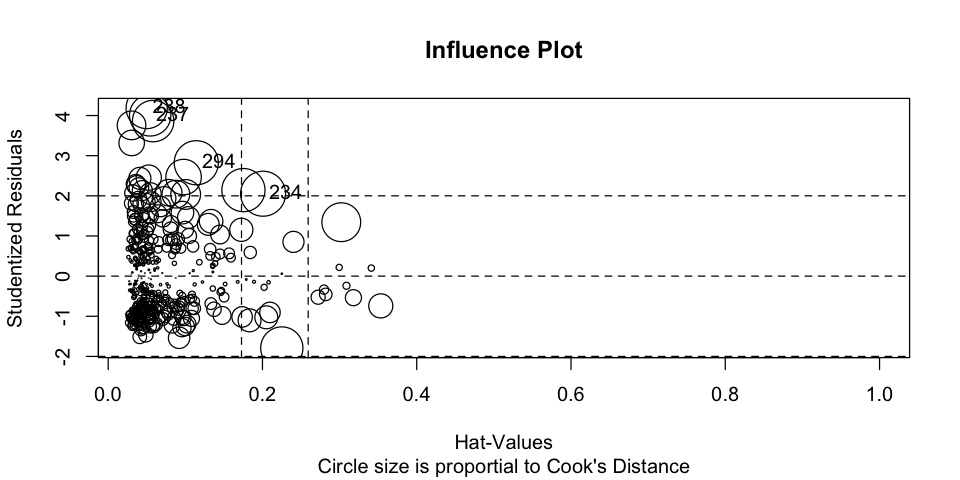

Removed infl. points: 5

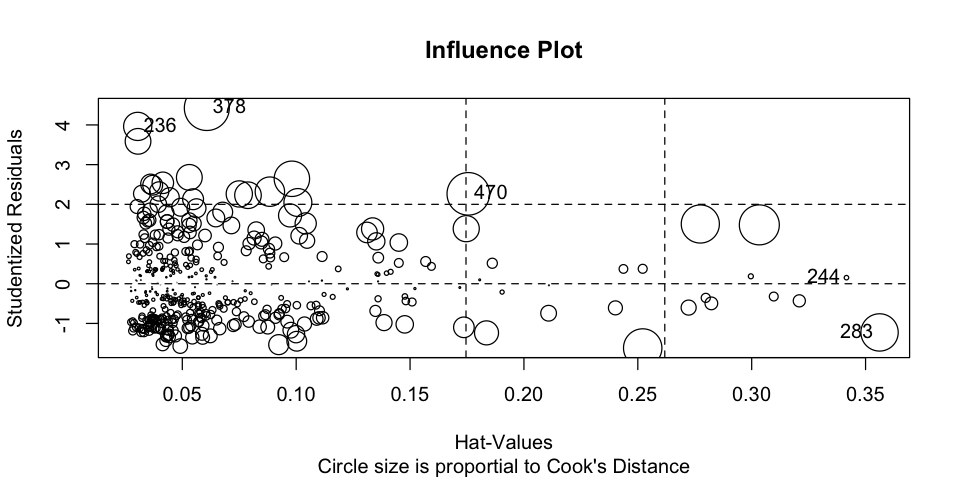

Removed infl. points: 6

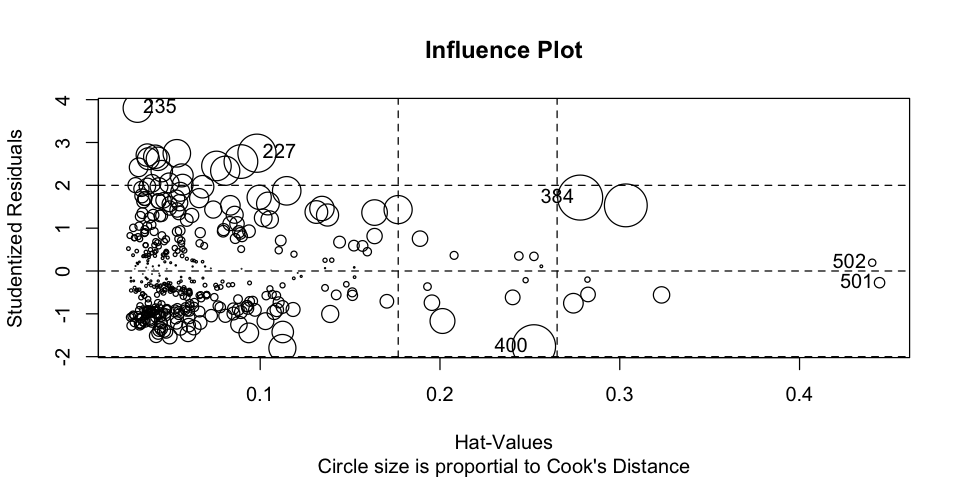

Removed infl. points: 6

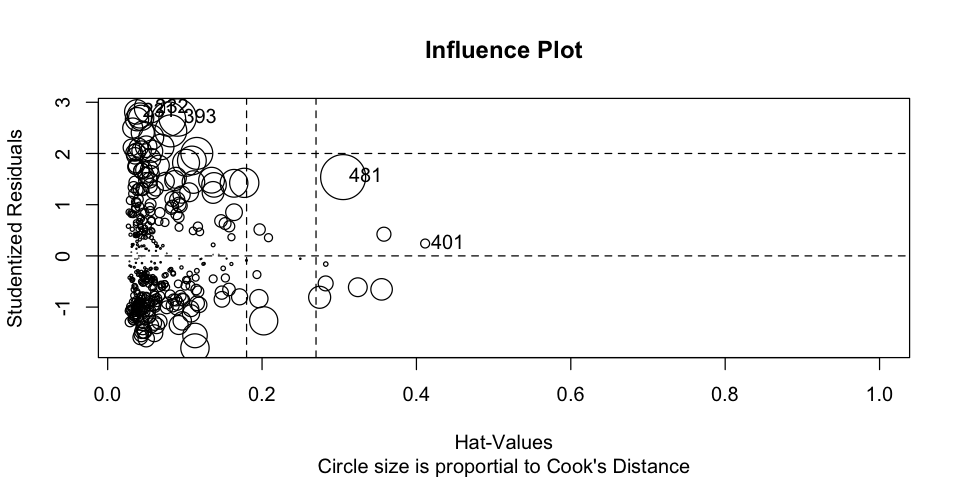

Removed infl. points: 5

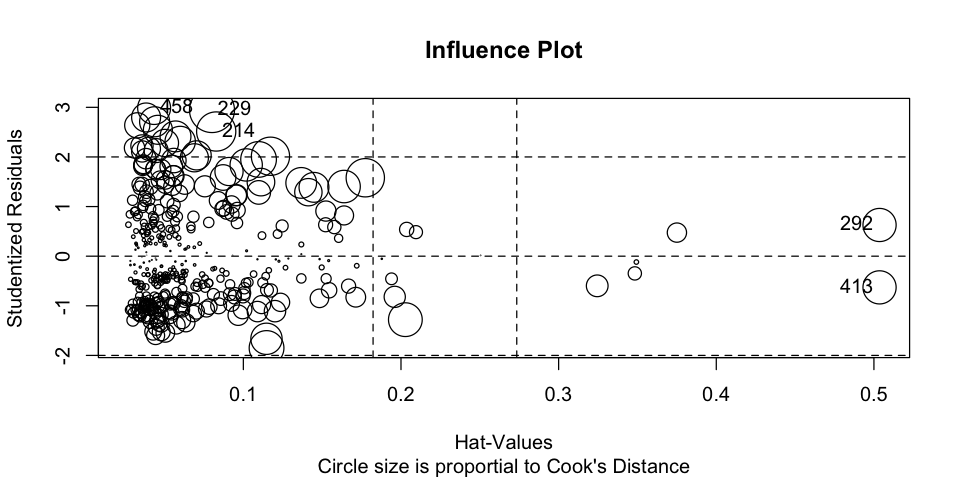

Removed infl. points: 6

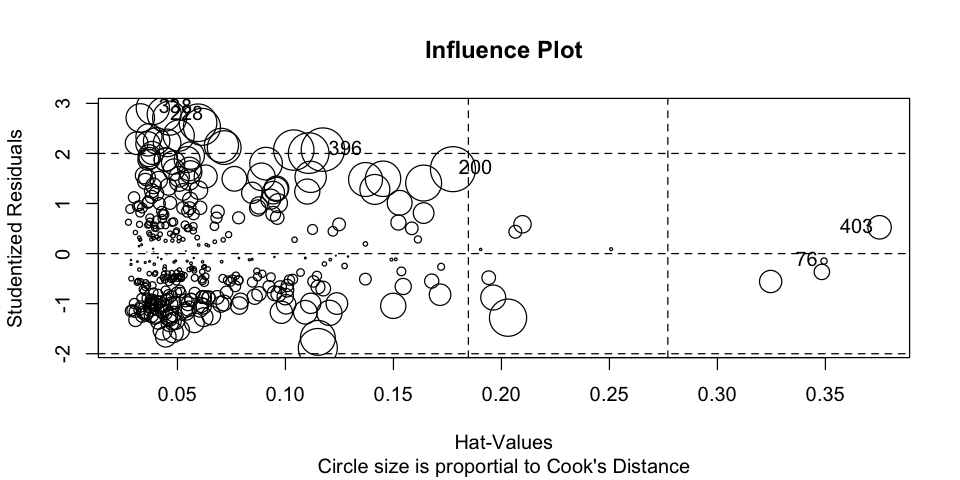

Removed infl. points: 6

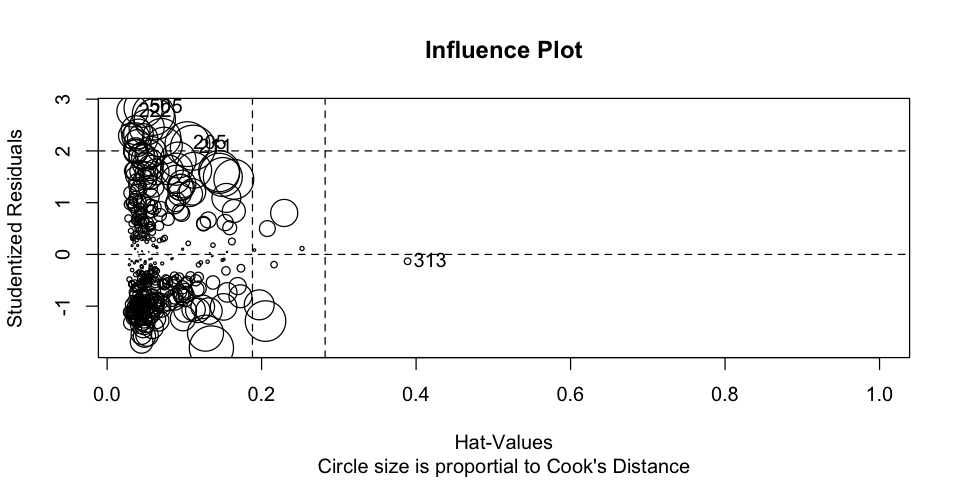

Removed infl. points: 5

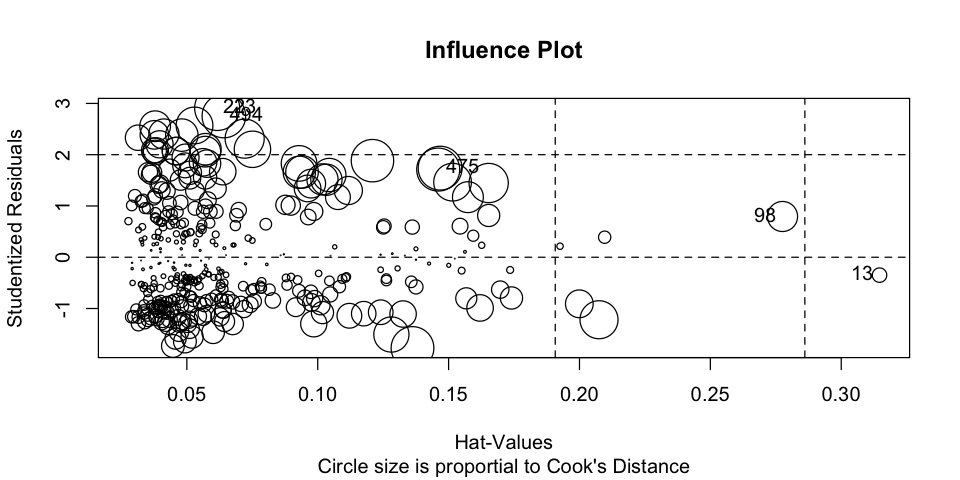

Removed infl. points: 6

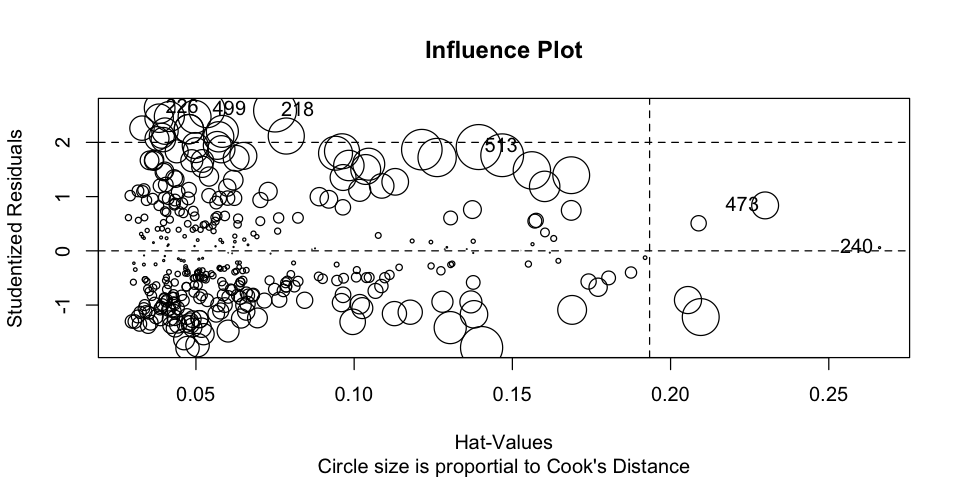

Removed infl. points: 6

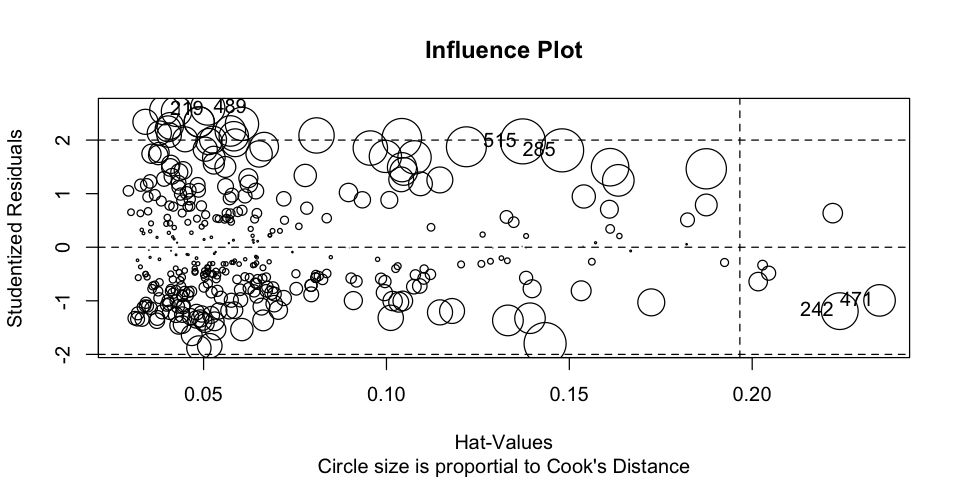

Removed infl. points: 5

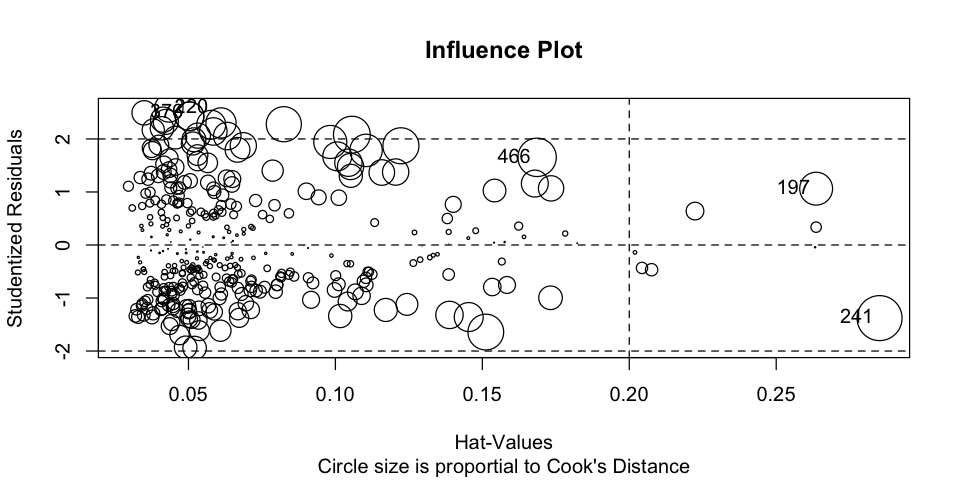

Removed infl. points: 6

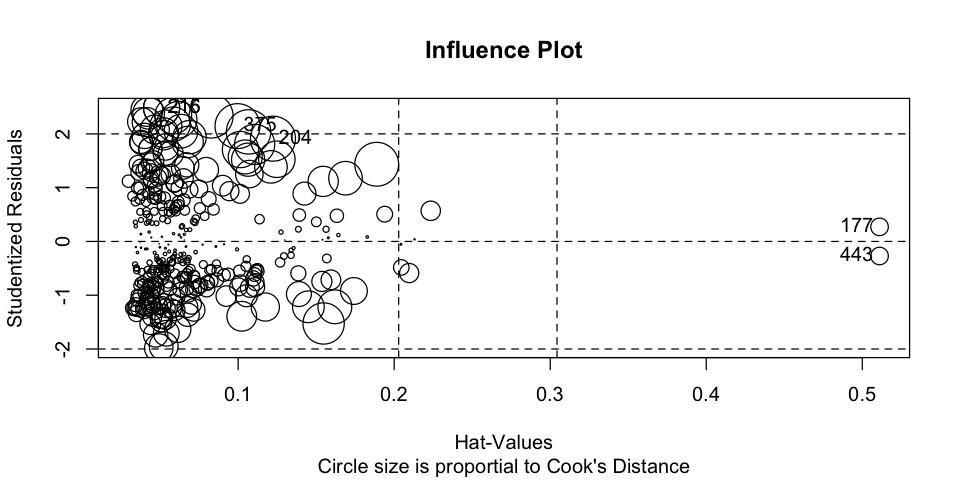

Removed infl. points: 6

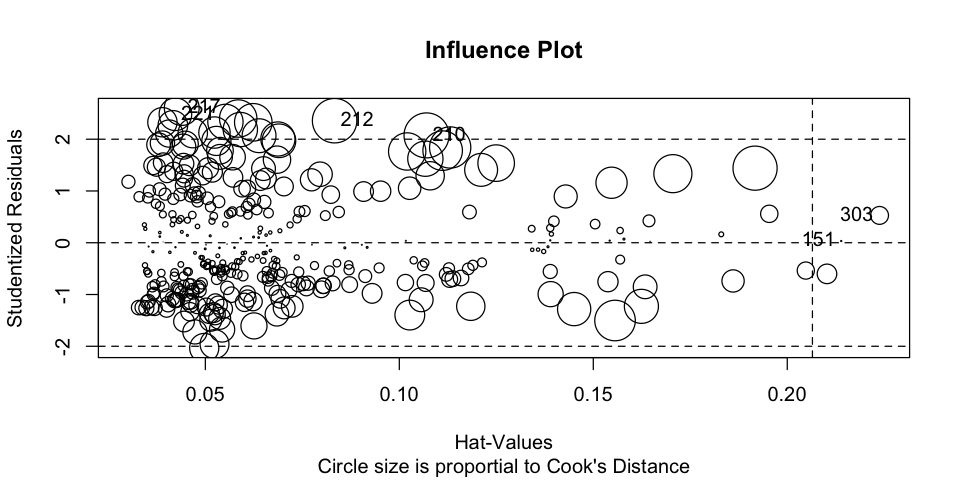

Removed infl. points: 6

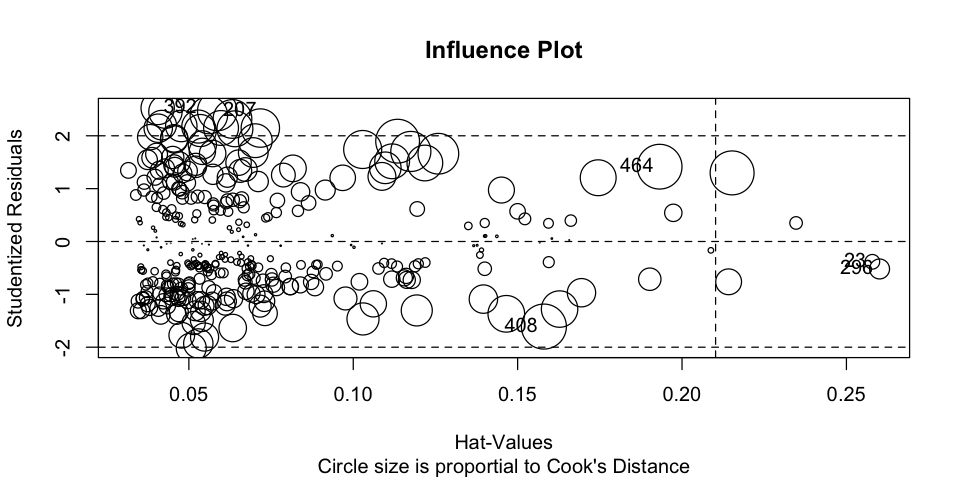

Removed infl. points: 5

[1] 0.181703

value      numdf      dendf 
  4.239914  22.000000 299.000000

[1] 322

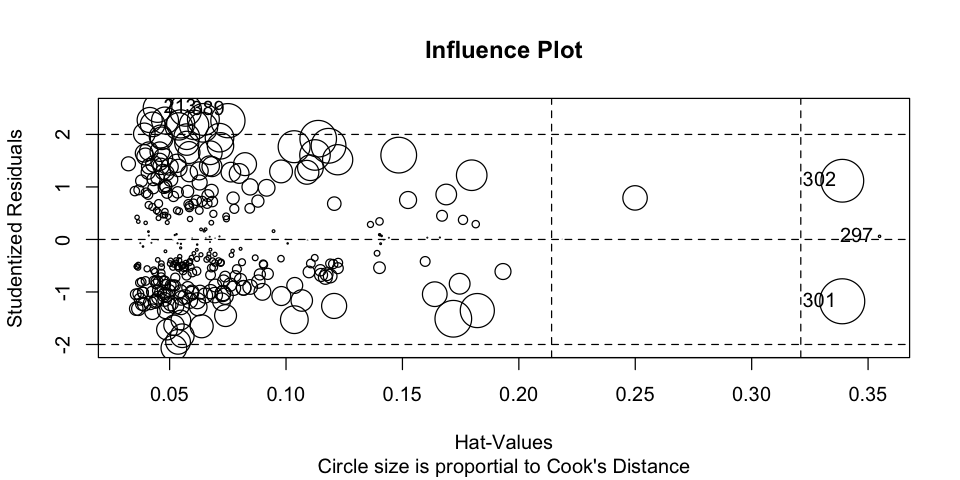

In [32]:
options(repr.plot.width=8, repr.plot.height=4)
for (i in 1:15) {
    if (summary(linmod)$adj.r.squared < 0.5) {
        linmod <- lm(area~.-day-RH-ISI, data=train.data2)
        train.data2 <- clean_infl_points(linmod, train.data2)
        linmod <- lm(area~.-day-RH-ISI, data=train.data2)
    }
}
summary(linmod)$adj.r.squared
summary(linmod)$fstatistic
nrow(train.data2)


In [33]:
summary(linmod)


Call:
lm(formula = area ~ . - day - RH - ISI, data = train.data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5967 -0.5928 -0.2097  0.5604  1.8258 

Coefficients: (12 not defined because of singularities)
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.88003    2.75881  -2.494  0.01318 *  
FFMC         4.43967    2.31954   1.914  0.05657 .  
DMC         -0.77358    0.42294  -1.829  0.06839 .  
DC           4.15745    1.83463   2.266  0.02416 *  
temp        -0.03792    0.38594  -0.098  0.92180    
wind         0.04072    0.25899   0.157  0.87516    
rain              NA         NA      NA       NA    
month_apr         NA         NA      NA       NA    
month_aug    0.18235    0.16270   1.121  0.26328    
month_dec    2.50590    0.48767   5.138 5.01e-07 ***
month_feb    2.97420    1.09175   2.724  0.00682 ** 
month_jan         NA         NA      NA       NA    
month_jul    0.41533    0.31776   1.307  0.19220    
month_jun         NA         NA      NA 

After running this process several times, we see that our test still detects influential points constantly and keeps removing datapoints. After removing around 20% of our training data, the results of our model are not improving much. The adj. r squared is only around 18% and we have lost a lot of information in this process. The following graphs show problematic conditions for supporting the use of the linear model as our residuals don't seem to be randomly spread around 0 (interestingly, the Normal Q-Q plot shows that the standardized residuals are not deviating a lot from the dashed line, however in the Residuals vs Fitted, the residuals don't seem normally distributed around 0 as they present some sort of linear behaviour in the negative part) therefore is better to look for a different approach in order to get a better fit.  
Finally, the summary of the model shows several of the variables it NA, which can be due to collinearity. The removal of the data can be very expensive as we have very limited amount of observations compared to the number of predictors once the dummy variables are implemented

#### Diagnostic Plots for the linear model fit
- The first plot below, corresponding to residuals vs fitted, shows again that the residuals are not randomly spread around 0, because we can observe a pattern, therefore, it is not a good indication that we have linear relationships.
- As mentioned before, for the Q-Q plot, it can be seen that the standardized residuals deviate at the beginning from the dashed line and at the end, however it could be argued that they could still be considered following the pattern of the dashed line. However the plot analized before shows that the trend (red line) might seem close to the 0 horizontal line but the spread of the residuals doesn't look random.
- The scale-location plot is showing that the residuals are not equally spread in the ranges of the predictors. This can be concluded because the red line (trend) is not presenting a horizontal line with randomly spread points. Again, the residuals don't seem randomly spread.
-  Finally, the Residuals vs leverage is not showing issues with outliers/influential points, which was expected as the focus of this model was to remove this points in order to check for a better fit.

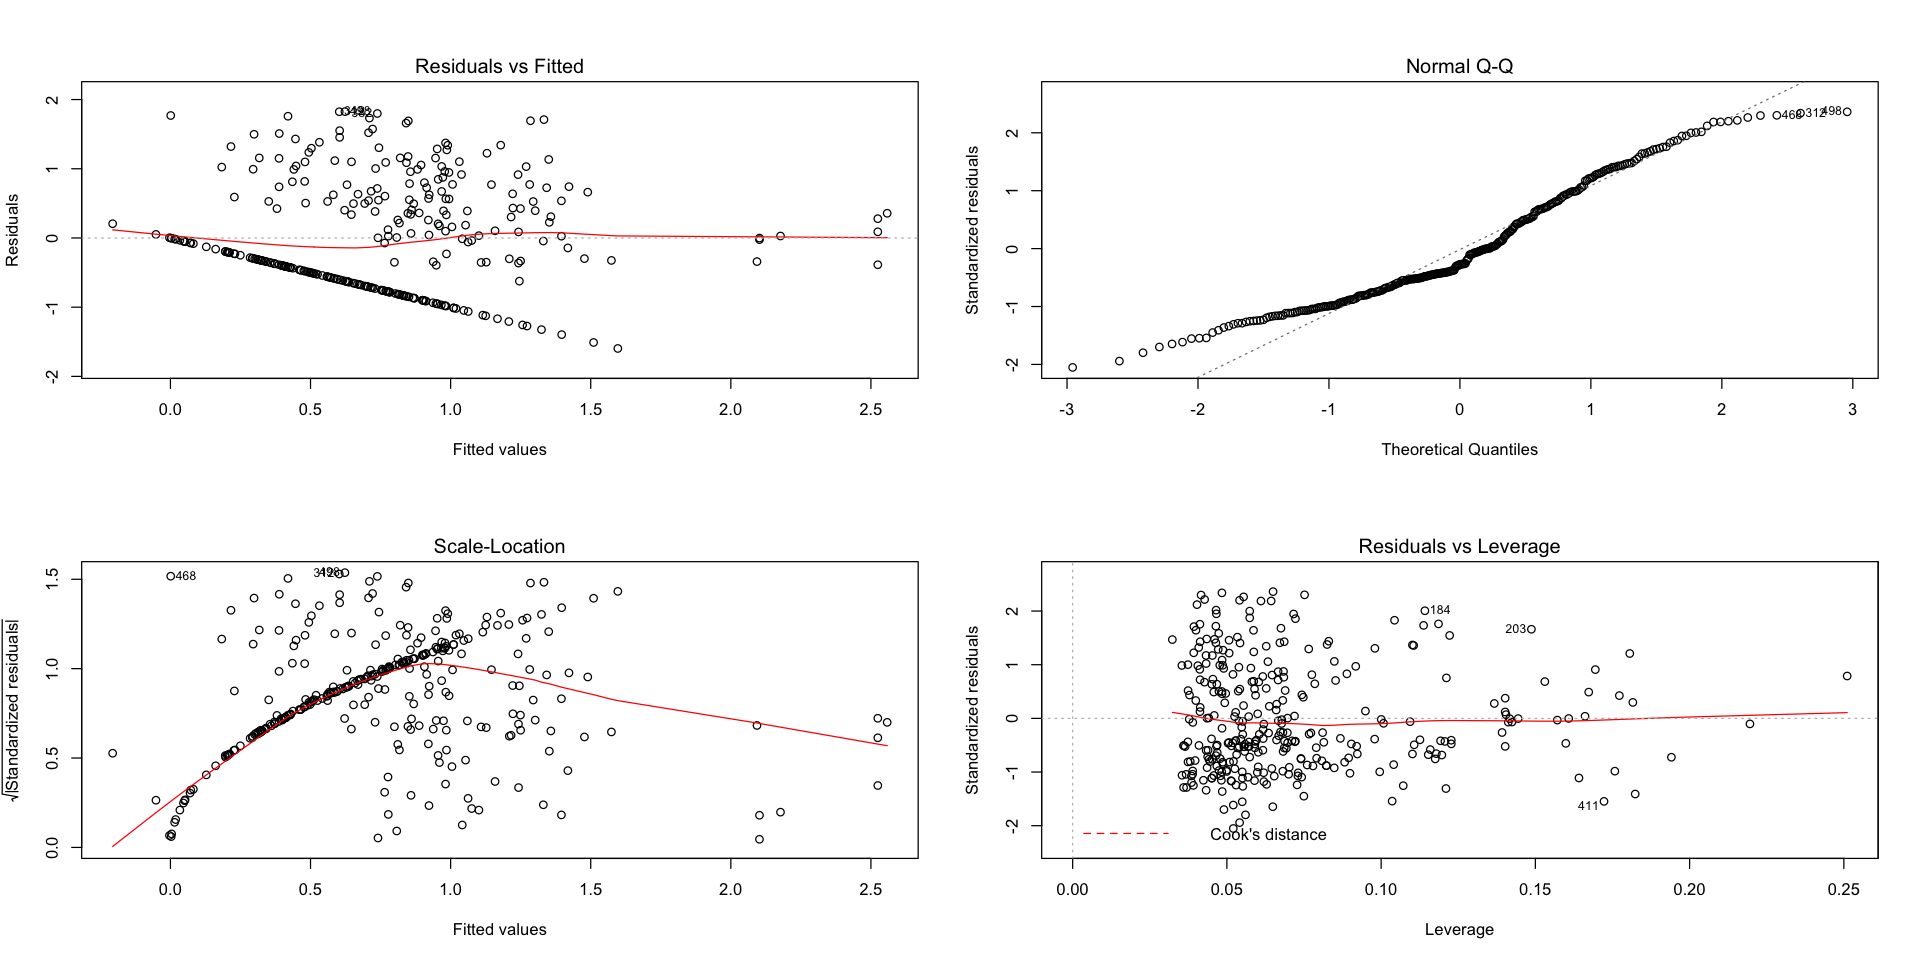

In [34]:
options(repr.plot.width=16, repr.plot.height=8)
par(mfrow=c(2,2))
plot(linmod)

### Subset selection

In [35]:
# install.packages('leaps')
library(leaps)
subset.fit <- regsubsets(area~.-day,train.data,nvmax = 30)
summsubset <- summary(subset.fit)
names(summsubset)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“3  linear dependencies found”


Reordering variables and trying again:


[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

In [36]:
names(subset.fit)

[1] "np"        "nrbar"     "d"         "rbar"      "thetab"    "first"    
 [7] "last"      "vorder"    "tol"       "rss"       "bound"     "nvmax"    
[13] "ress"      "ir"        "nbest"     "lopt"      "il"        "ier"      
[19] "xnames"    "method"    "force.in"  "force.out" "sserr"     "intercept"
[25] "lindep"    "reorder"   "nullrss"   "nn"        "call"

In [37]:
paste("Lowest BIC: ",eval(parse(text= min(summsubset$bic))))
which.min(summsubset$bic)
paste("Best adj_r-sq: ",eval(parse(text= max(summsubset$adjr2))))
which.max(summsubset$adjr2)
summsubset$which[4,]
# summsubset$which[,c(0:5,20:26)]

[1] "Lowest BIC:  -5.31923570264729"

[1] 3

[1] "Best adj_r-sq:  0.0881977791214233"

[1] 18

(Intercept)        FFMC         DMC          DC         ISI        temp 
       TRUE       FALSE        TRUE       FALSE       FALSE       FALSE 
         RH        wind        rain   month_apr   month_aug   month_dec 
      FALSE       FALSE       FALSE       FALSE       FALSE        TRUE 
  month_feb   month_jan   month_jul   month_jun   month_mar   month_may 
      FALSE       FALSE       FALSE       FALSE       FALSE       FALSE 
  month_nov   month_oct   month_sep         X_1         X_2         X_3 
      FALSE       FALSE       FALSE       FALSE       FALSE        TRUE 
        X_4         X_5         X_6         X_7         X_8         X_9 
      FALSE       FALSE       FALSE       FALSE       FALSE       FALSE 
        Y_2         Y_3         Y_4         Y_5         Y_6         Y_8 
      FALSE       FALSE       FALSE       FALSE       FALSE        TRUE 
        Y_9 
      FALSE

We can observe that after performing the subset selection, we evaluate every possible model with the linear combinations, and the the best adjusted r-squared is only around 9% (the model uses some of the X,Y coordinates, month, and DMC). Therefore, our evaluation of all the possible linear models using the subset selection is not giving a good performance and a different approach should be implemented.

### Linear model including some Interaction terms
We will now include some interaction terms, that showed some correlation in the corr matrix from above the Data Exploration section. This second model will be implemented with the first model as the base in order to perform an anova test and check whether this terms are improving the fit. Here, we will consider the model before removing all the outliers. For the new model we will drop the ISI component as it showed the highest correlation value in our Exploratory analysis and include the interaction terms to be evaluated.

In [38]:
base.model <- lm(area~.-day, data=train.data)
summary(base.model)$adj.r.squared
linmod2 <- lm(area~.-day-ISI+DC:temp+RH:rain, data=train.data)
summary(linmod2)$adj.r.squared

[1] 0.06199619

[1] 0.07590582

#### ANOVA test.
The results of the Adj. R-Squared show an increase in the model performance, now we will perform the anova test to validate this. 

In [39]:
anova(base.model, linmod2)

Res.Df RSS      Df Sum of Sq F        Pr(>F)     
1 379    674.8055 NA       NA        NA          NA
2 378    663.0448  1 11.76076  6.704776 0.009986884

The results of the ANOVA test show a low p-value (0.01), so we can consider that the two models are statistically different. From this we can conclude that adding an interaction between the predictors `DC`:`temp` and `RH`:`rain` is improving the performance.

#### Remove influence points for 15 rounds
We will now remove some influential points as we did before and see the performance of the new model with interaction terms.

Removed infl. points: 6

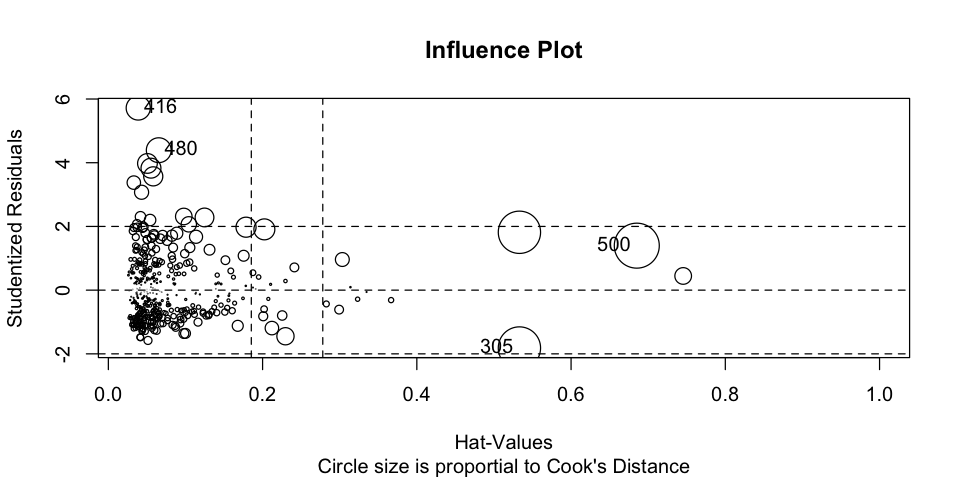

Removed infl. points: 6

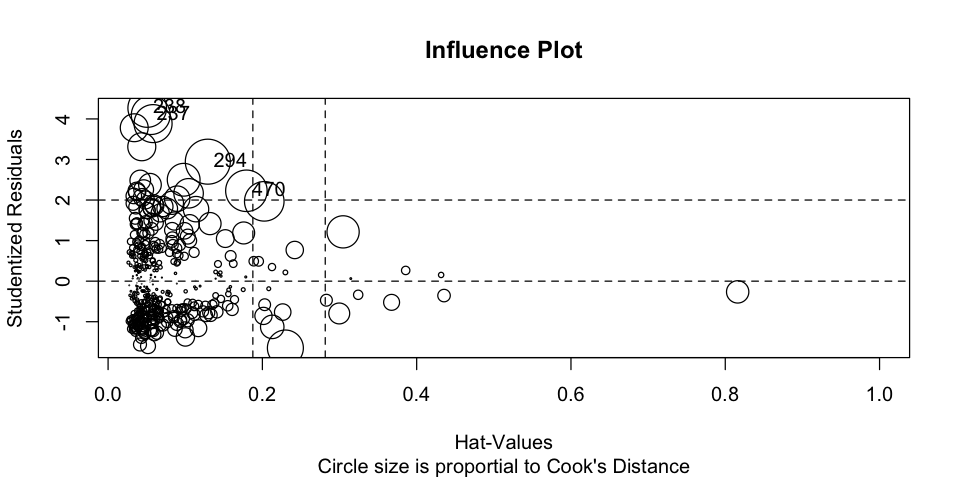

Removed infl. points: 5

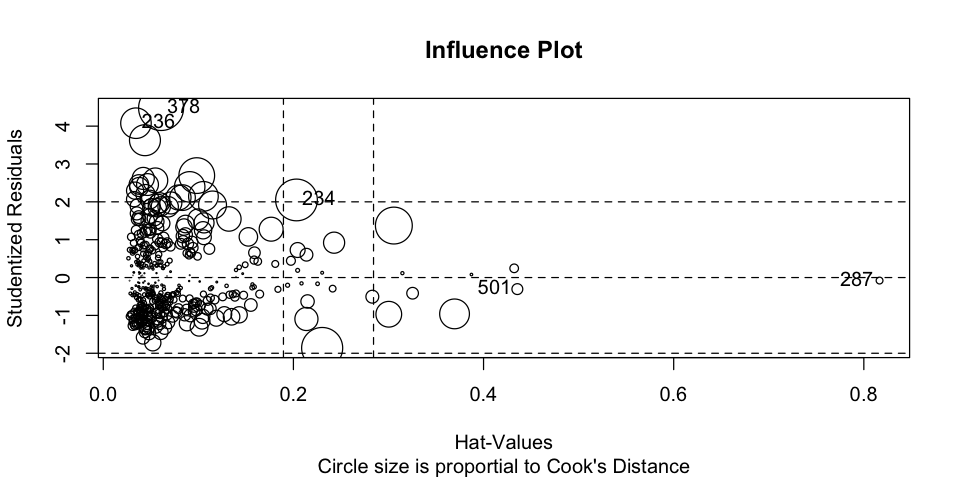

Removed infl. points: 6

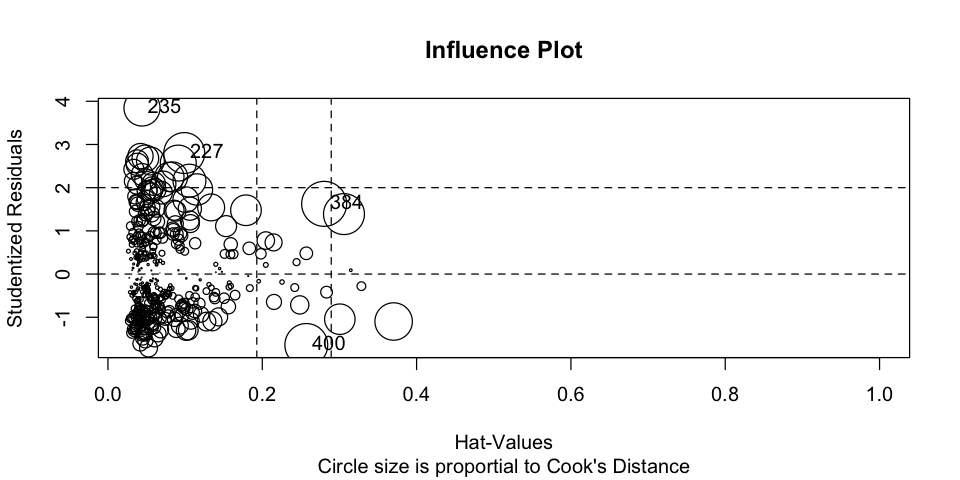

Removed infl. points: 5

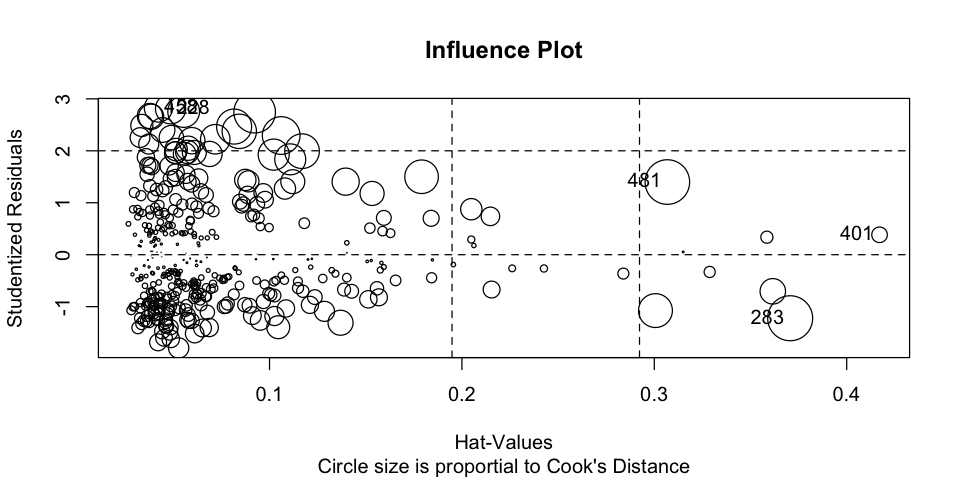

Removed infl. points: 5

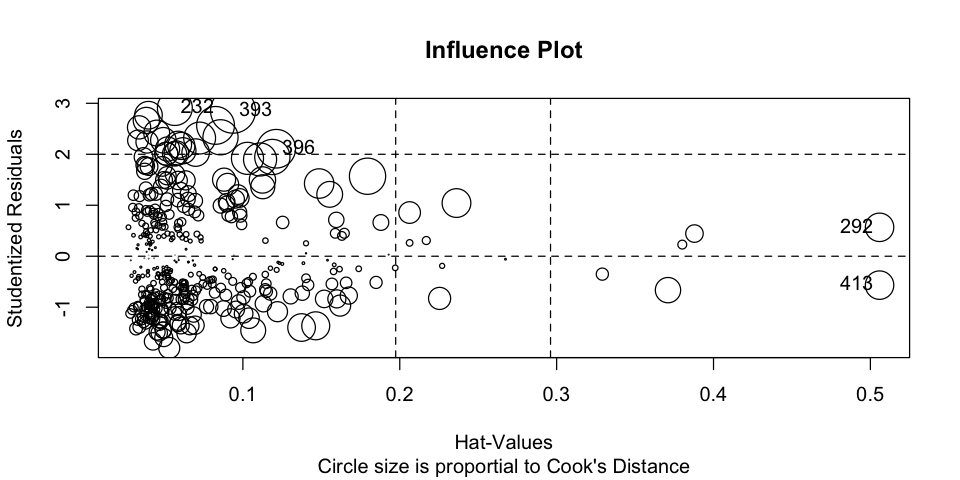

Removed infl. points: 6

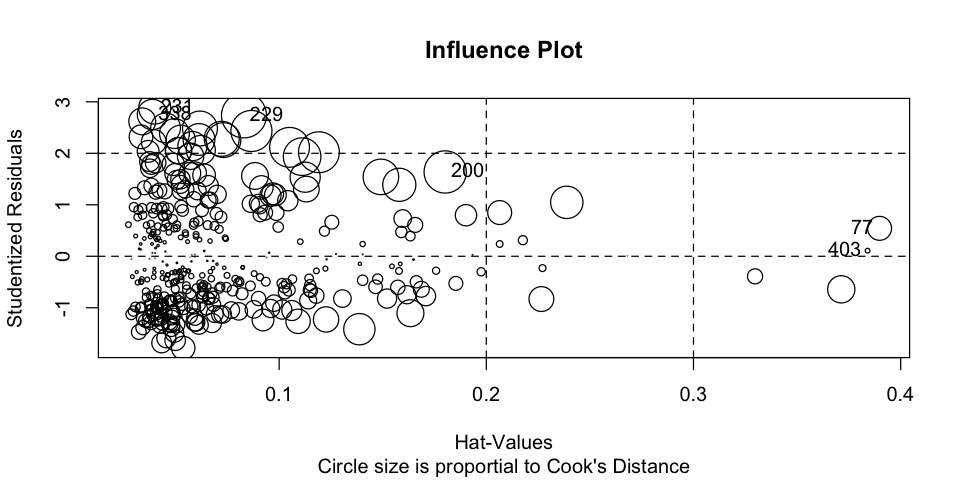

Removed infl. points: 6

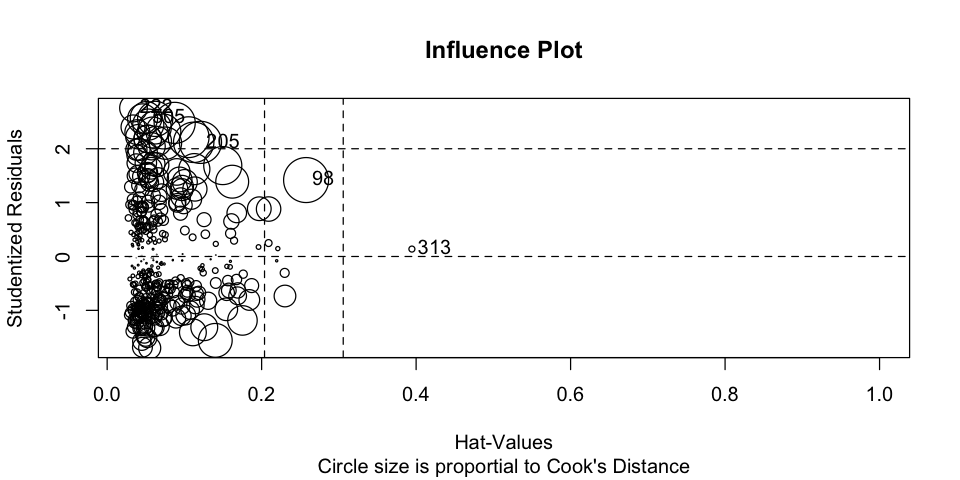

Removed infl. points: 6

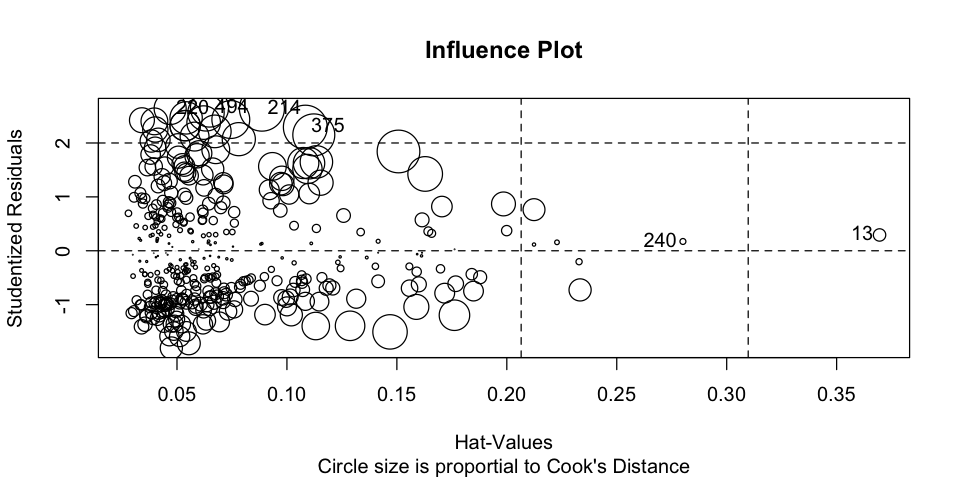

Removed infl. points: 5

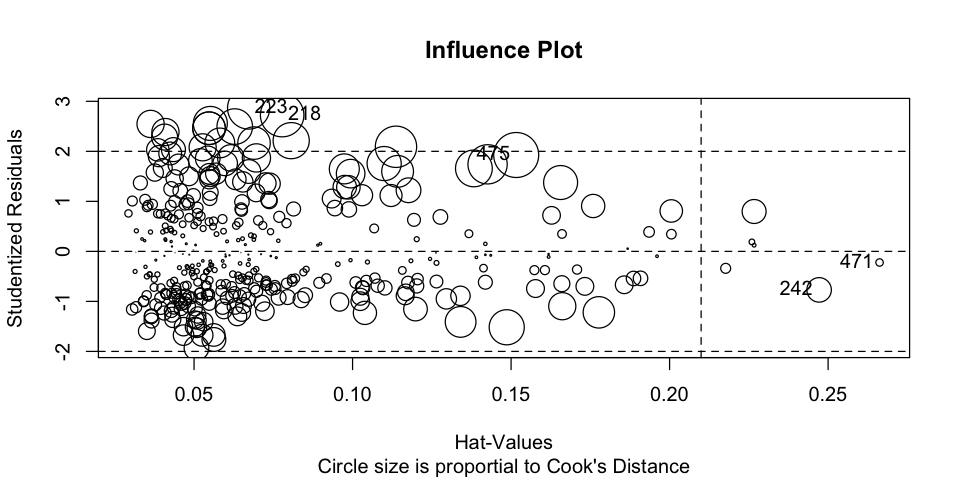

Removed infl. points: 6

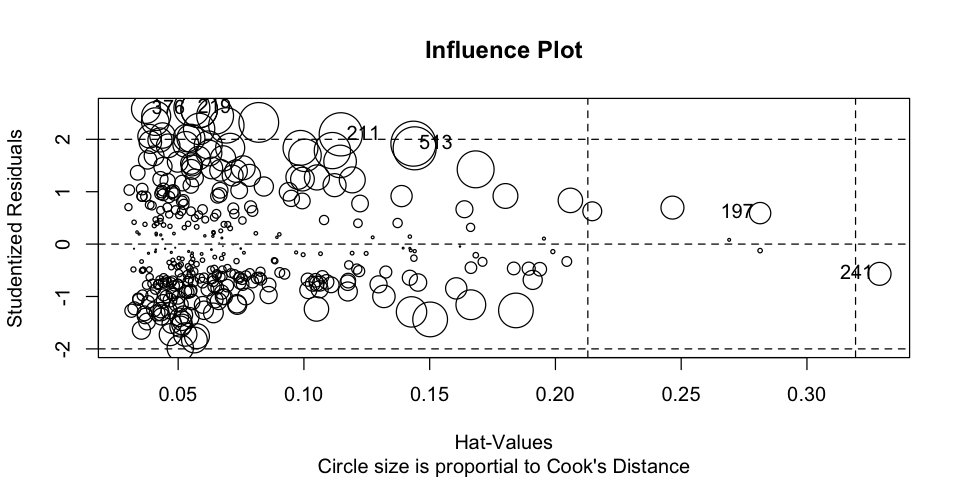

Removed infl. points: 6

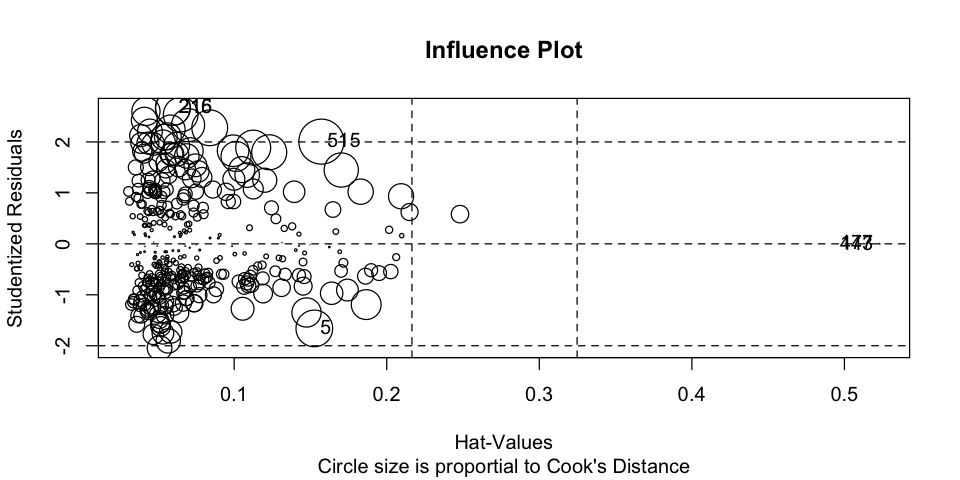

Removed infl. points: 6

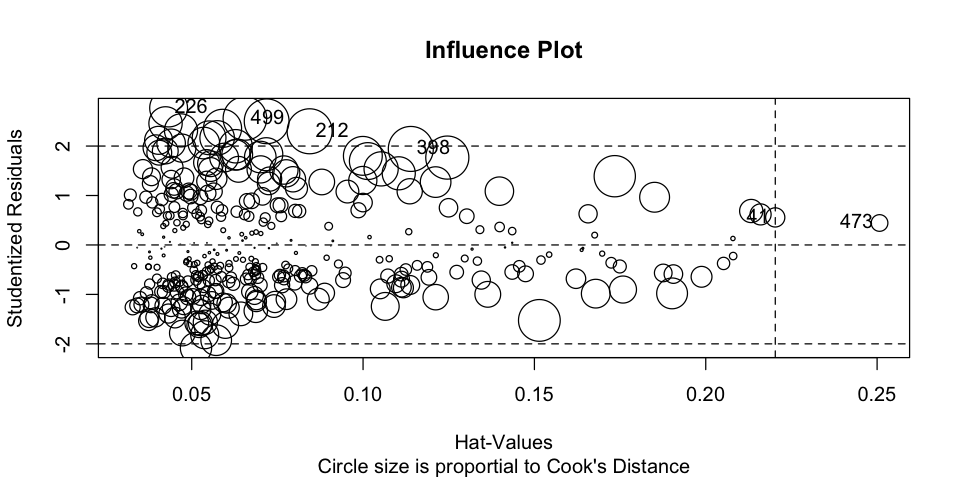

Removed infl. points: 5

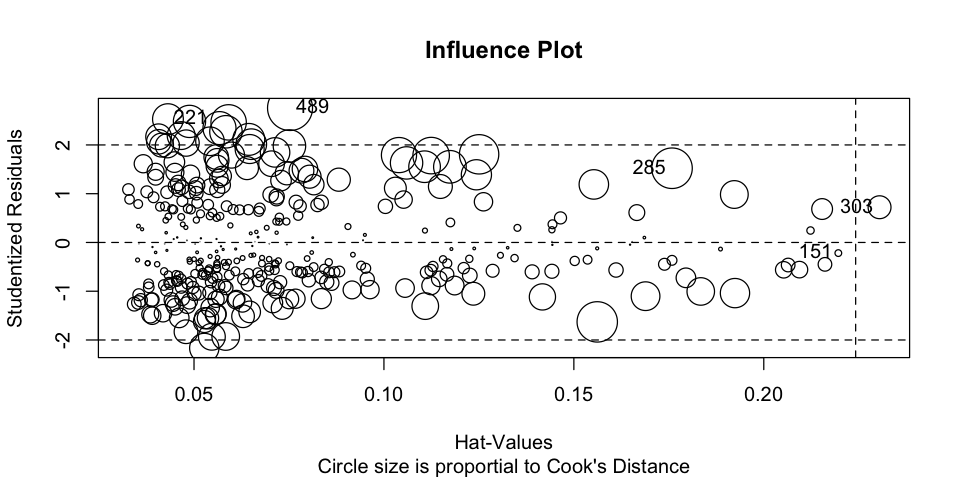

Removed infl. points: 6

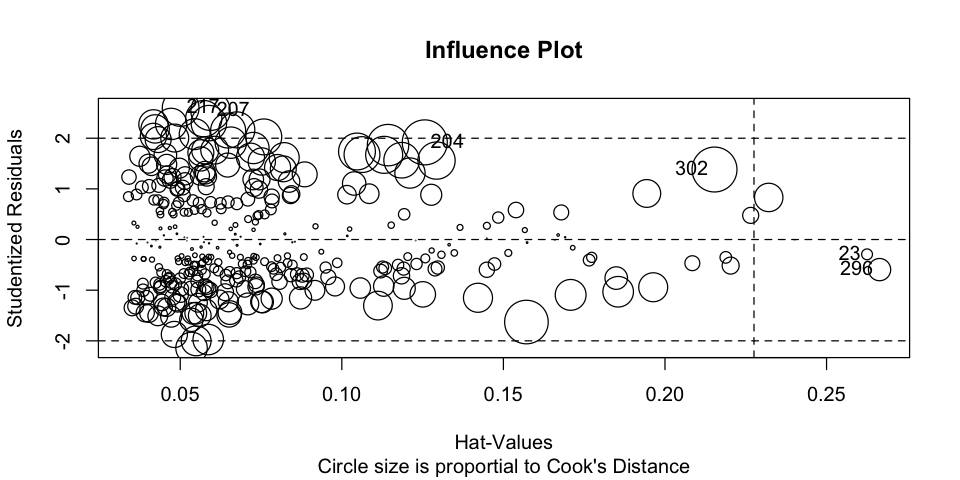

Removed infl. points: 6

[1] 0.2123312

value      numdf      dendf 
  4.605488  24.000000 297.000000

[1] 322

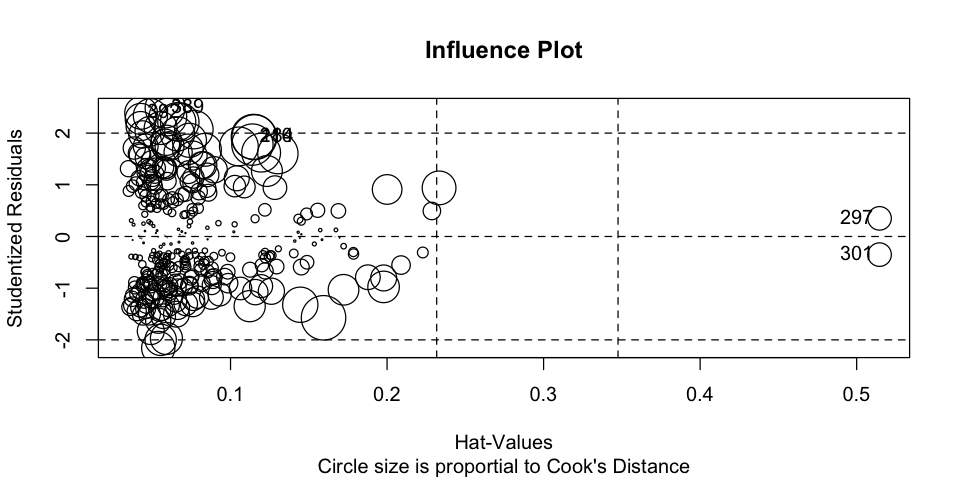

In [40]:
options(repr.plot.width=8, repr.plot.height=4)
train.data2 <- clean_infl_points(linmod2, train.data)
for (i in 1:15) {
    if (summary(linmod2)$adj.r.squared < 0.5) {
        linmod2 <- lm(area~.-day-ISI+DC:temp+RH:rain, data=train.data2)
        train.data2 <- clean_infl_points(linmod2, train.data2)
        linmod2 <- lm(area~.-day-ISI+DC:temp+RH:rain, data=train.data2)
    } else {print('R-sq improved')}
}
summary(linmod2)$adj.r.squared
summary(linmod2)$fstatistic
nrow(train.data2)

In [41]:
summary(linmod2)


Call:
lm(formula = area ~ . - day - ISI + DC:temp + RH:rain, data = train.data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6562 -0.6030 -0.1606  0.5453  1.9152 

Coefficients: (13 not defined because of singularities)
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.051167   2.909457  -1.736 0.083580 .  
FFMC         6.620080   2.523307   2.624 0.009151 ** 
DMC         -0.980418   0.430277  -2.279 0.023402 *  
DC          -0.352092   1.963868  -0.179 0.857836    
temp        -7.561629   2.140086  -3.533 0.000476 ***
RH           0.294487   0.509084   0.578 0.563389    
wind         0.012423   0.254760   0.049 0.961141    
rain               NA         NA      NA       NA    
month_apr          NA         NA      NA       NA    
month_aug    0.137998   0.161770   0.853 0.394320    
month_dec    2.251065   0.548532   4.104 5.26e-05 ***
month_feb    2.025573   1.062726   1.906 0.057613 .  
month_jan          NA         NA      NA       NA    
month_jul  

#### Results of influential points removal
Again a similar situation is observed and after removing several influential points we still achieve a low Adjusted R-squared of around 21%, with significance for the months, FFMC, DMC, and temp as well as the coordinates and the interaction DC:temp; We get a p-value for the F-statistic that rejects $H_0$. With this we can conclude that, although the model is not presenting a high R-squared, it is still useful as we have a low p-value for the F-statistic and we can consider that this model can explain around 20% of the variation

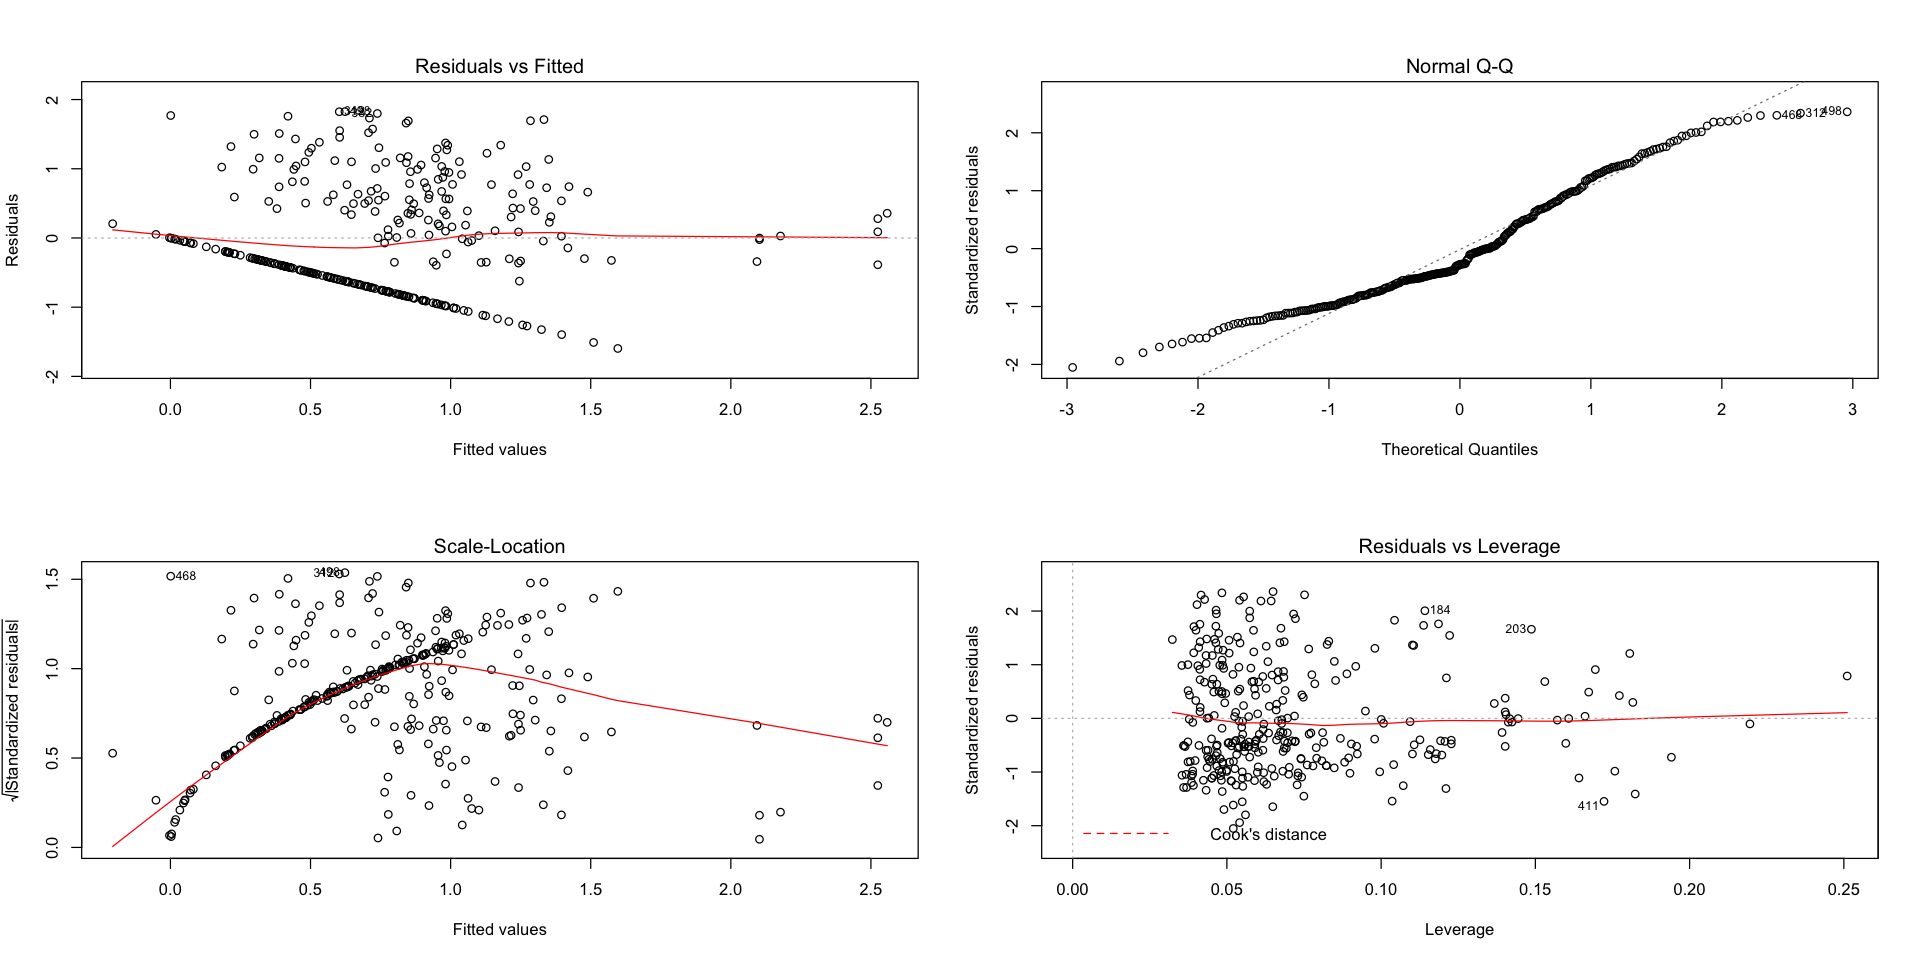

In [42]:
options(repr.plot.width=16, repr.plot.height=8)
par(mfrow=c(2,2))
plot(linmod)

The behaviour of the residuals of our model observed above is still not as desired. Taking into consideration that this model relies in a linear relationship between the predictors and the response, and also depends on n>>p, which means we want the number of observations to be considerably larger with respect to the number of parameters. This last reason is a limitation of this last approach, as we are introducing some extra parameters and then we are forced to remove some influential points, making our n even smaller.

In [43]:
pred <-as.vector(predict(linmod2,test.data)^3)
test.label <- as.vector(test.data[,10]^3)
RMSE(pred,test.label)

Warning message in predict.lm(linmod2, test.data):
“prediction from a rank-deficient fit may be misleading”


[1] 108.5381

As we can observe above, after removing some predictors to improve the Ajusted R-squared, and include some interactions for the variables that present a high correlation (as observed in the graphs of the Exploration section), we obtained an adjusted R-squared that is so far the best one, but is still a low fit. 

Although this approach was useful for getting a better fit, we will now try to use another approach in order to perform the feature selection. Now we will implement the step function.

### Feature selection 2
In this section we use the step function to perform the feature selection. This is a combination of forward and backward stepwise selection, where the variables are added to the model sequentially but after this the function may also remove variables that are not considered as significant anymore. With this approach the model can emulate the behaviour of subset selection which was used before, but is very computationally heavy.

In [44]:
fit.lm <- step(linmod2)
summary(fit.lm)

Start:  AIC=-126.63
area ~ (day + FFMC + DMC + DC + ISI + temp + RH + wind + rain + 
    month_apr + month_aug + month_dec + month_feb + month_jan + 
    month_jul + month_jun + month_mar + month_may + month_nov + 
    month_oct + month_sep + X_1 + X_2 + X_3 + X_4 + X_5 + X_6 + 
    X_7 + X_8 + X_9 + Y_2 + Y_3 + Y_4 + Y_5 + Y_6 + Y_8 + Y_9) - 
    day - ISI + DC:temp + RH:rain


Step:  AIC=-126.63
area ~ FFMC + DMC + DC + temp + RH + wind + rain + month_apr + 
    month_aug + month_dec + month_feb + month_jan + month_jul + 
    month_jun + month_mar + month_may + month_nov + month_oct + 
    month_sep + X_1 + X_2 + X_3 + X_4 + X_5 + X_6 + X_7 + X_8 + 
    X_9 + Y_2 + Y_3 + Y_4 + Y_5 + Y_6 + Y_8 + Y_9 + DC:temp


Step:  AIC=-126.63
area ~ FFMC + DMC + DC + temp + RH + wind + rain + month_apr + 
    month_aug + month_dec + month_feb + month_jan + month_jul + 
    month_jun + month_mar + month_may + month_nov + month_oct + 
    month_sep + X_1 + X_2 + X_3 + X_4 + X_5 + X_6 + X_7 + X_8 + 



Call:
lm(formula = area ~ FFMC + DMC + DC + temp + month_dec + month_feb + 
    month_oct + X_1 + X_3 + X_4 + X_5 + X_6 + X_7 + Y_2 + Y_4 + 
    Y_5 + DC:temp, data = train.data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6176 -0.5825 -0.1731  0.5474  1.9187 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.9458     2.1063  -0.924 0.356331    
FFMC          5.8144     2.4069   2.416 0.016293 *  
DMC          -0.5841     0.3187  -1.833 0.067783 .  
DC           -2.7035     1.0078  -2.682 0.007707 ** 
temp         -7.3273     1.9848  -3.692 0.000264 ***
month_dec     1.6630     0.3380   4.921 1.42e-06 ***
month_feb     0.5125     0.3459   1.482 0.139448    
month_oct    -0.7231     0.2914  -2.482 0.013605 *  
X_1          -0.2324     0.1648  -1.410 0.159533    
X_3          -0.8975     0.1711  -5.246 2.91e-07 ***
X_4          -0.5530     0.1486  -3.720 0.000237 ***
X_5          -0.7105     0.2107  -3.372 0.000843 ***
X_6          -0.4193 

With the step function, we obtain that the model with the lowest AIC contains only `FFMC`, `DC`, `DMC`, `temp`, `month_dec`, `month_feb`, `month_oct` and some `X`, `Y` coordinates, as well as the interaction `DC:temp`; eliminating several variables that were not significant, therefore, we obtain a much simpler model which we expect will produce a better adj. R-Squared.

In [45]:
# names(fit.lm)
linmod.step <- eval(fit.lm$call)
summary(linmod.step)


Call:
lm(formula = area ~ FFMC + DMC + DC + temp + month_dec + month_feb + 
    month_oct + X_1 + X_3 + X_4 + X_5 + X_6 + X_7 + Y_2 + Y_4 + 
    Y_5 + DC:temp, data = train.data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6176 -0.5825 -0.1731  0.5474  1.9187 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.9458     2.1063  -0.924 0.356331    
FFMC          5.8144     2.4069   2.416 0.016293 *  
DMC          -0.5841     0.3187  -1.833 0.067783 .  
DC           -2.7035     1.0078  -2.682 0.007707 ** 
temp         -7.3273     1.9848  -3.692 0.000264 ***
month_dec     1.6630     0.3380   4.921 1.42e-06 ***
month_feb     0.5125     0.3459   1.482 0.139448    
month_oct    -0.7231     0.2914  -2.482 0.013605 *  
X_1          -0.2324     0.1648  -1.410 0.159533    
X_3          -0.8975     0.1711  -5.246 2.91e-07 ***
X_4          -0.5530     0.1486  -3.720 0.000237 ***
X_5          -0.7105     0.2107  -3.372 0.000843 ***
X_6          -0.4193 

In [46]:
pred <-as.vector(predict(linmod.step,test.data)^3)
test.label <- as.vector(test.data[,10]^3)
RMSE(pred,test.label)

[1] 108.255

So far, the step selection has given the best of all models with an adj. R-squared of 22%.

### CV - Checking for Polynomials in best models.
In this section, we will conclude this approach by using K-fold validation to fit some polynomials and see if we can do better than the models obtained before. The polynomials will be implemented in the best model we reach without removing outliers and also in the model removing outliers. The following cell shows the values of the delta component of the `cv.glm` function, which gives the average mean squared error. 

#### Model 1 polynomial check

In [49]:
library(boot)
set.seed(11)
cv.error1=rep(0,5)
for (i in 1:5){
    glm.fit1=glm(area ~ poly(FFMC,i) + poly(DMC,i) + DC + temp + month_dec+month_feb+month_oct +X_1+X_3+X_4+X_5+X_6+X_7+Y_2+Y_4+Y_5+
                 DC:temp, data = train.data2)
    cv.error1[i]=suppressWarnings(cv.glm(train.data2,glm.fit1,K=10)$delta[1])
}
cv.error1

[1] 0.6625575 0.6494345 0.6701640 0.6766817 0.6712130

integer(0)

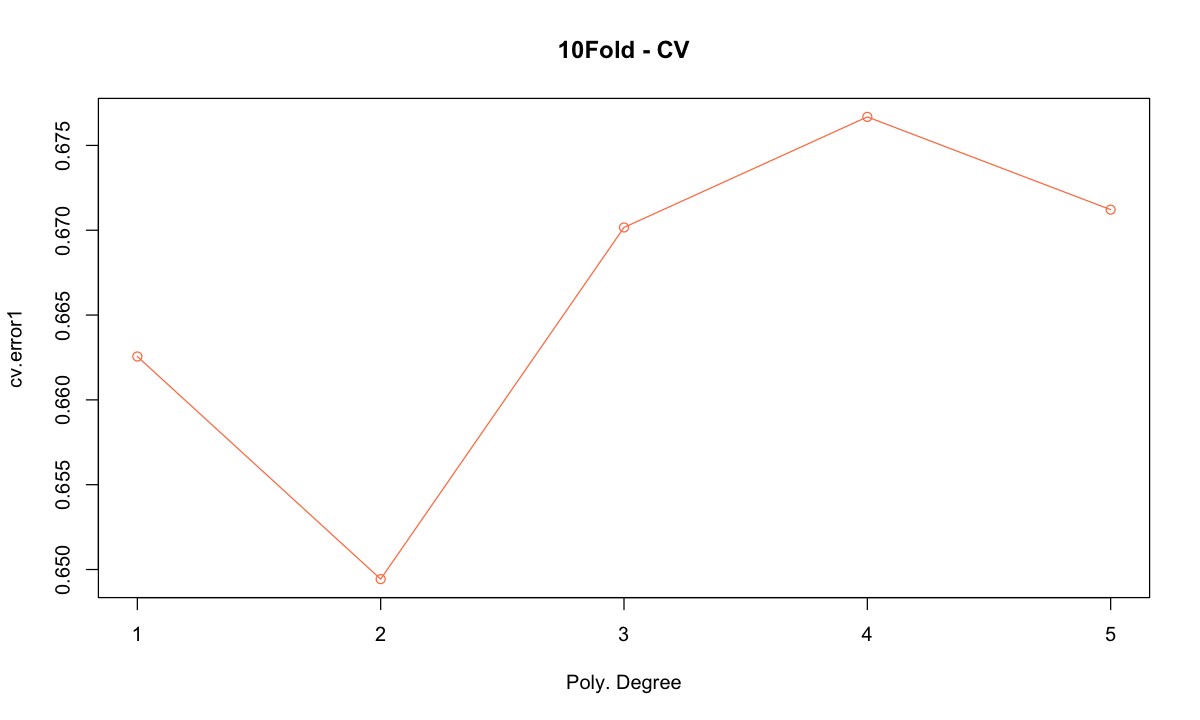

In [51]:
options(repr.plot.width=10, repr.plot.height=6)
plot(cv.error1,type='o',col='coral',xlab='Poly. Degree')+title('10Fold - CV')

#### Model 2 polynomial check

In [52]:
set.seed(11)
cv.error2=rep(0,5)
for (i in 1:5){
    glm.fit2=glm(area ~ DMC + poly(DC,i) + temp + month_aug+month_dec+month_jan + X_1+X_2+X_3+X_4+X_5+X_6+X_7+X_8 + 
                    Y_2+Y_3+Y_4+Y_5+Y_6+Y_8 + DC:temp, data = train.data)
    cv.error2[i]=suppressWarnings(cv.glm (train.data ,glm.fit2,K=10)$delta[1])
}
cv.error2

[1] 1.907144 1.946944 1.908080 1.959245 1.980392

integer(0)

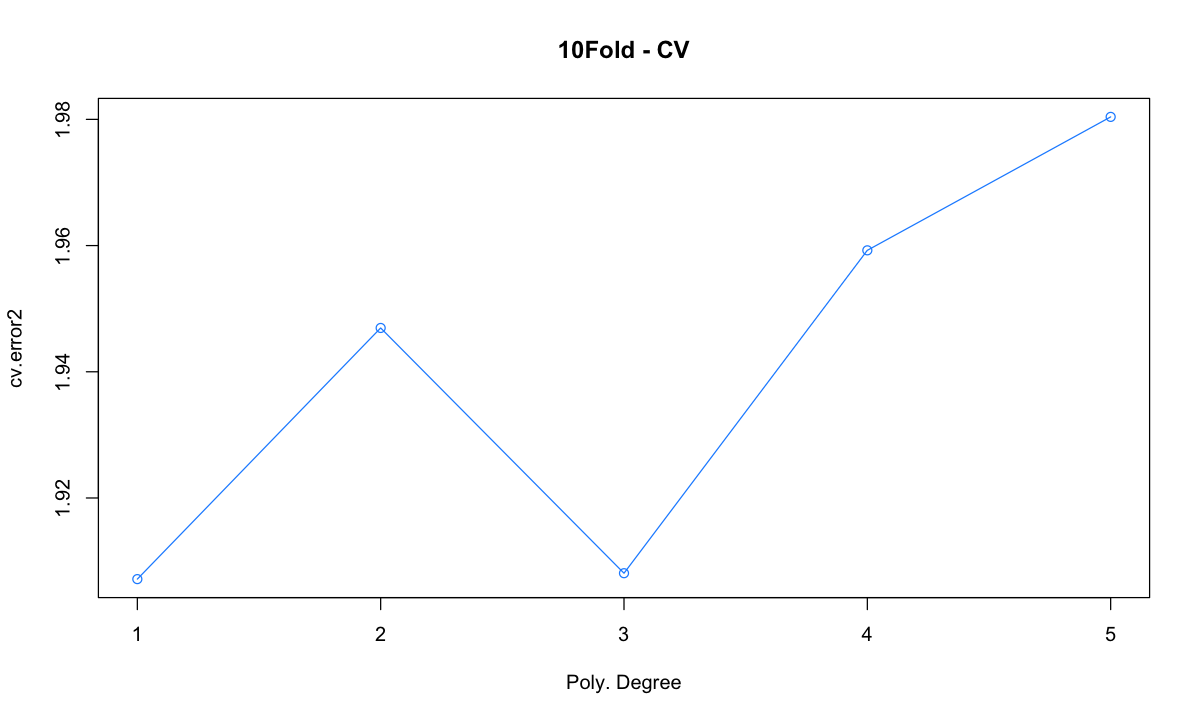

In [53]:
plot(cv.error2,type='o',col='dodgerblue',xlab='Poly. Degree')+title('10Fold - CV')

From the graphs above, it can be seen that adding the polynomial term to the first model (the one that removes the outliers) seems to reduce the mse for a second degree polynomial in the terms FFMC and DMC. However, this might not be statistically significant, so we will perform a ANOVA test once again to compare with the original model. 

In [54]:
glm.fit1=glm(area ~ poly(FFMC,2) + poly(DMC,2) + DC + temp + month_dec+month_feb+month_oct +X_1+X_3+X_4+X_5+X_6+X_7+Y_2+Y_4+Y_5+
                 DC:temp, data = train.data2)
anova(linmod.step, glm.fit1)

Res.Df RSS      Df Sum of Sq F         Pr(>F)   
1 304    187.9545 NA       NA         NA        NA
2 302    187.6375  2 0.316993  0.2550979 0.7750074

The ANOVA test indicates that the two models are not statistically significantly different, therefore we will prefer to use a simple model compared to a complex model, which means that the model without polynomial predictors is selected over the second one.

### Conclusion First Approach
In the previous section we explored a linear model with several variations in order to improve the fitting of it. As it was warned before, most of this process was used to illustrate the scope of this tuning of the model as the residuals plot showed a non random behavior of them.

It was found that, using the Cook's distance, there were several influential points. After the removal of several influential points, which ended up in a considerable diminution of the training data (around 20% of it) the achieved Adj. R-squared score was 18%.

Then we introduced the interaction terms `DC:temp` and `RH:rain` based on the exploratory analysis. With this, the performance increased and an ANOVA test between the models confirmed that the new model was statistically  better by including the interaction terms. Then, the removal of influence points and outliers produced an Adj. R-squared of 21.2%.

We used the `step()` function for feature selection which involves a mix between the forward and backward stepwise selection. With this approach it was observed that the model with the lowest AIC score removed several unnecessary features leaving only `FFMC`, `DMC`, `DC`, `temp`, and some of the dummy variables corresponding to the months and coordinates (only `DMC` had a p-value around 0.06, the rest of the variables kept in the model had p-values below 5%). The interaction variable introduced was also kept by the step function, showing that it was relevant for the model. With this approach the Adj. R-squared achieved its maximum level at 22.3%.

To conclude the assessment of this model, the use of a 10 fold Cross validation was implemented in order to evaluate the inclusion of a polynomial in the last model. Although it showed some improve for a second degree in the average MSE, after doing an ANOVA test to validate this, it was observed that the model was not statistically different with respect to the previous one that didn't include the polynomial, therefore, the simpler model was preferred. 

## Random Forest
The dataset we have been studying, seems to present non-linear relationships, observed before in the plots of the residuals from our models. Taking this into consideration, it is important to try a non-linear approach, which in this case is Random Forest in order to try to modelate this behavior in the data. 

In order to implement this model, we will first use the data without using dummy variables (as they are not required for this model) and then we will decide what number is most adequate as $m$ the number of predictors that are sampled at each split. However, the idea is to choose maximum half of the parameters in the dataset as we would like to reduce the correlation between trees (If we consider all the predictors like in bagging, then most of the predictions from the trees would be highly correlated, as most of them would follow a similar order on the selection of variables for splitting).

Finally, another advantage of Random Forest is that a bigger amount of trees is not expected to overfit.

### Preparing the dataset for training the model

In [56]:
# install.packages('randomForest')
library(randomForest)

rf.fires.data <- read.csv('forestfires.csv')

set.seed(12345)
smpl_size <- floor(0.8 * nrow(rf.fires.data))

# shuffle data
rf.fires.data2 <- rf.fires.data[sample(1:nrow(rf.fires.data),nrow(rf.fires.data)),]

# create  training and testing sets:
train.index = 1:smpl_size
rf.train.data <- rf.fires.data2[train.index, ] # grab the sample size rows for training
rf.test.data <- rf.fires.data2[-train.index, ] # grab the rows not used for training as testing

dim(rf.train.data) 
dim(rf.test.data)
str(rf.train.data)

[1] 413  13

[1] 104  13

'data.frame':	413 obs. of  13 variables:
 $ X    : int  1 4 6 4 4 4 1 5 7 2 ...
 $ Y    : int  2 4 5 4 4 3 2 4 4 4 ...
 $ month: Factor w/ 12 levels "apr","aug","dec",..: 2 12 8 12 8 2 12 12 11 2 ...
 $ day  : Factor w/ 7 levels "fri","mon","sat",..: 7 5 2 1 3 3 5 1 1 6 ...
 $ FFMC : num  95.5 92.9 90.1 92.1 91.7 94.2 92.9 93.3 90 94.8 ...
 $ DMC  : num  99.9 137 39.7 99 35.8 ...
 $ DC   : num  513.3 706.4 86.6 745.3 80.8 ...
 $ ISI  : num  13.2 9.2 6.2 9.6 7.8 11 9.2 13.9 8.7 17 ...
 $ temp : num  23.3 20.8 15.2 15.4 17 21.4 21.5 27.6 11.3 20.1 ...
 $ RH   : int  31 17 27 53 27 44 15 30 60 40 ...
 $ wind : num  4.5 1.3 3.1 6.3 4.9 2.7 0.9 1.3 5.4 4 ...
 $ rain : num  0 0 0 0 0 0 0 0 0 0 ...
 $ area : num  0.55 0 31.86 7.31 28.66 ...


### Building the model 
In this section we have a look at the RMSE for the different values that our $m$ variable can take. As it can be observed in the following graph, the lowest values are located at 5 and 9 parameters, however, as stated before, we will prefer the use of 5 parameters because in this way the trees used in the Random Forest will be less correlated in the predictions. 

In [57]:
m.params = seq(1,11)
area.test = rf.test.data[,'area']
set.seed(123)

error.df = data.frame('params'=m.params,'rmse'=rep(0,length(m.params)))
for (i in m.params) {
    rf.model = randomForest(area~.-day,data=rf.train.data,mtry=i,importance=TRUE)
    pred.rf = predict(rf.model,newdata = rf.test.data)
    error.df[i,'rmse'] = sqrt(mean((pred.rf-area.test)^2)) # Root mean square error
}

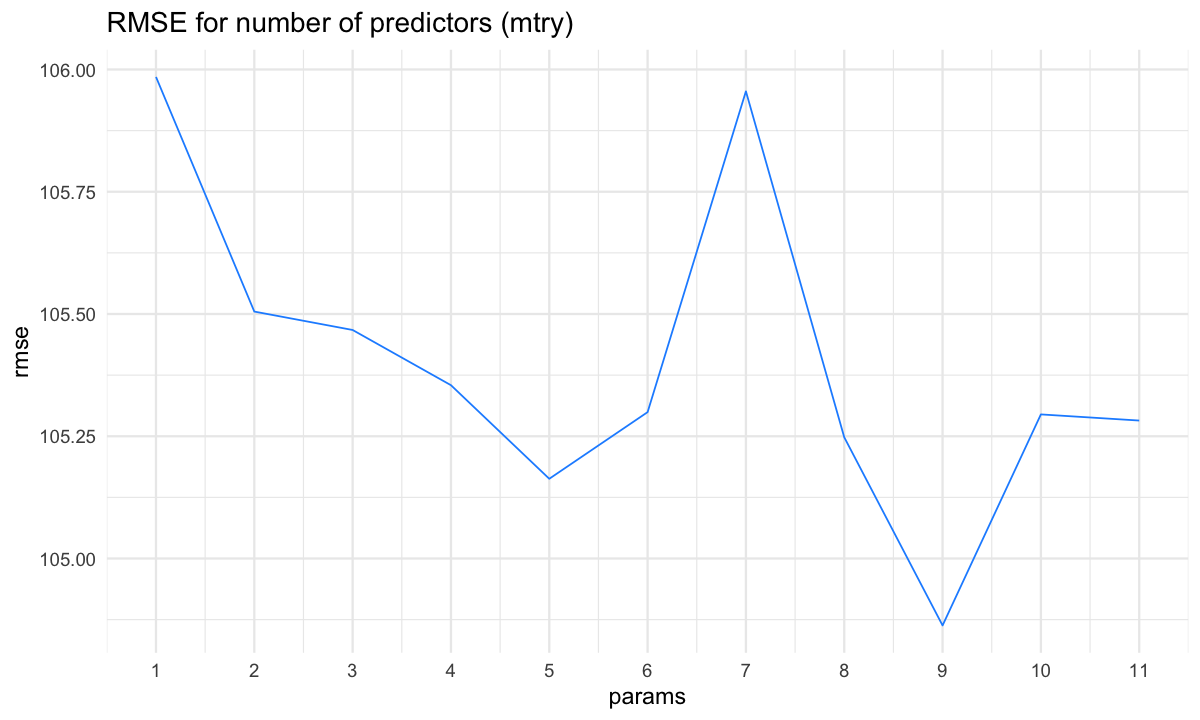

In [58]:
ggplot(data=error.df, aes(x=params, y=rmse)) + geom_line(color='dodgerblue') + scale_x_continuous(breaks=seq(1,11))+
         labs(title='RMSE for number of predictors (mtry)') +theme_minimal(base_size = 14)

### Final model with $m = 5$ and 500 trees

In [59]:
set.seed(123)
rf.model = randomForest(area~.-day,data=rf.train.data,mtry=5,importance=TRUE)
pred.rf = predict(rf.model,newdata = rf.test.data)
area.test = rf.test.data[,'area']
sqrt(mean((pred.rf-area.test)^2)) # Root mean square error

[1] 104.9698

### Variables Identified
The following table includes the `%IncMSE` score for the Random Forest model. Here we can observe the increase in the MSE of the predictions when the variable is excluded from the model. This value is calculated on the out of bag samples (the samples that were not included in the construction of the tree). According to the graph of the table, the variables `RH` and `DC` are the most important, followed by `month`. 

In [60]:
importance(rf.model)

%IncMSE    IncNodePurity
X     -3.4887305  29437.0800  
Y     -2.3077716  44443.3957  
month  4.0839175  16457.1138  
FFMC   2.6458694  46280.2202  
DMC    3.4243785 131331.5757  
DC     4.4313944  57946.7615  
ISI    3.4256555  33569.0543  
temp   0.3319326 169651.0197  
RH     4.9009710  81454.3711  
wind  -0.1940851  50335.3029  
rain  -0.5615016     18.0518

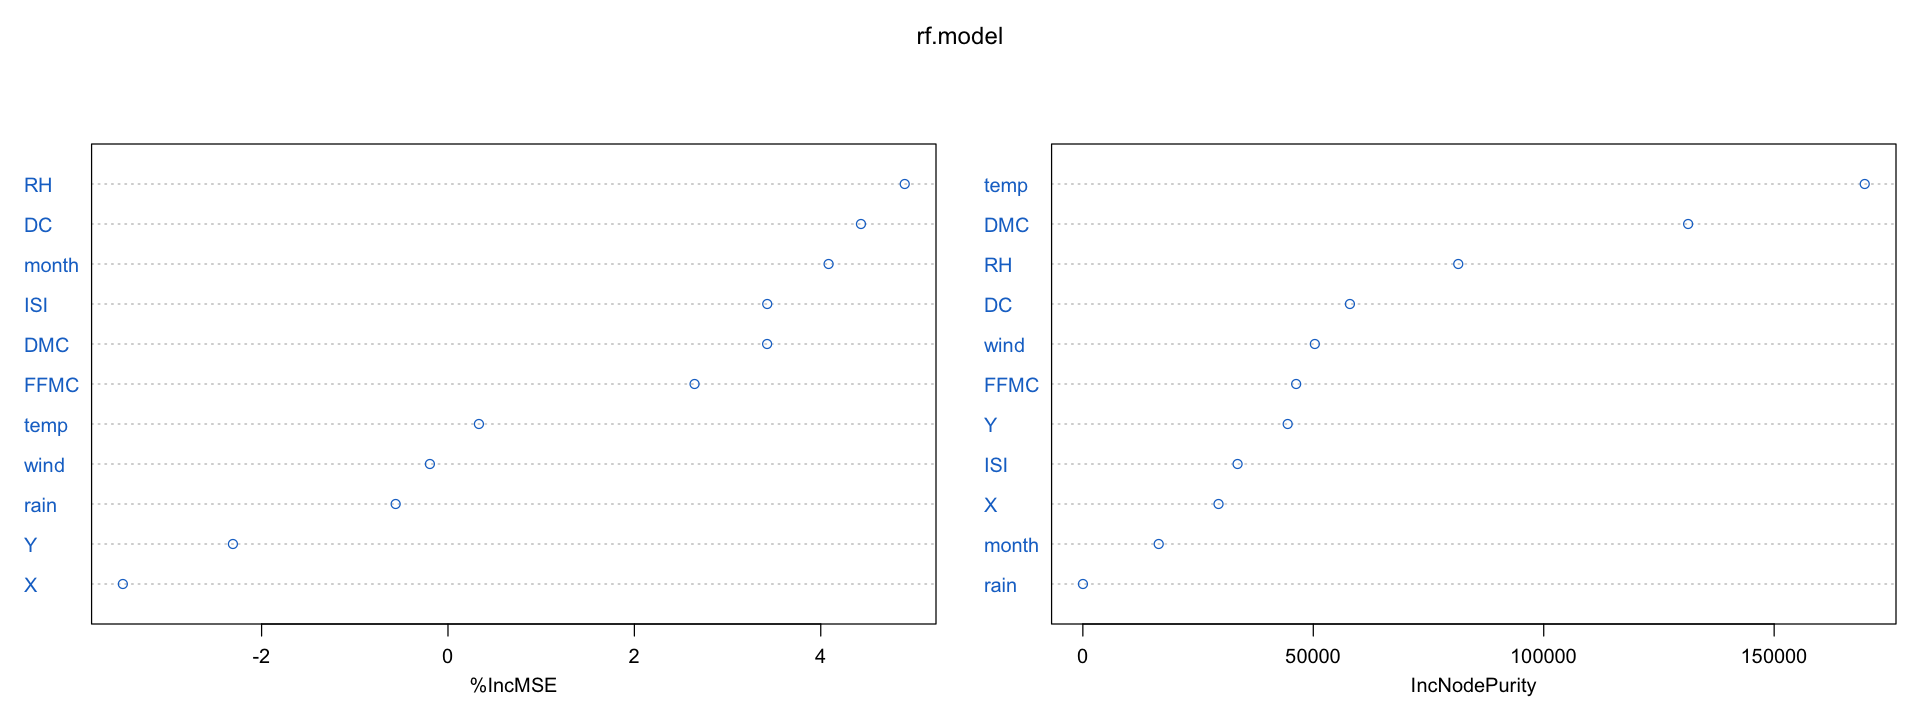

In [61]:
options(repr.plot.width=16, repr.plot.height=6)
varImpPlot(rf.model,color='dodgerblue3')

# Model Comparison<a class="anchor" id="sec_4"></a>
After implementing the linear approach with several variations and the non-linear approach through the use of Random Forest, it could be observed that the first technique provides a big amount of tools to tune the model in order to achieve better results, therefore, yielding a better interpretability of the outcomes. However, it could also be observed that this linear model, as indicated in its name, requires a linear relationship between the predictors and the target variable, which is an assumption that is not easy to find in the dataset at a first glance. For this reason the first model requires an exhaustive process of transformation and inspection of outliers and influential points in order to get the training data in a better shape for the model, whereas the non-linear approach relaxes this constraint and requires less pre-processing in order to achieve good results because it can learn more complex patterns in the training data. 

The downside of the Random Forest is that it sacrifices some of the interpretability in order to improve the prediction accuracy through the use of multiple trees, however, an advantage is that by setting `m`, the amount of parameters sampled for each split, as less than half of the total available parameters in the training dataset, the collinearity of the predictions is reduced compared to other non-linear approaches. 

Some of the tools available in the linear approach that were considered in this method were the analysis of adj. R-squared, the introduction of interaction terms, the use of anova tests to compare the models, the feature selection through the use of step (forward and backward stepwise selection), and the use of 10 Fold CV to evaluate a polynomial relationship in the model. All of this tools were useful to improve the fitting of the model, however, the Random Forest could outperform the linear approach with less tuning as it can fit better this dataset which seems to contain complex non-linear relationships. This limitation for the linear model was also magnified as the inclusion of the dummy variables for the categorical variables increased the amount of $p$ predictors with a very limited amount of available information which affected the assumption of $n>>p$ (i.e. we expect the amount of observations to be much greater than the amount of predictors)

Finally in the following cells we can observe the results for the estimated RMSE for the two models in order to compare the performance and variability of their predictions using bootstrap.
## RMSE for predictions of the final models using bootstrap

In [62]:
# data should contain predicted in 1st column and target in 2nd column
RMSE.boot <- function(data, index) {
    data <- data[index,]
    data.len = nrow(data)
    se <- 0
    for (i in 1:data.len) {
        se <- se + (data[i,1]-data[i,2])^2 #predicted[i]-target[i])^2
    }
    return (sqrt(se/data.len))
}

pred <-as.vector(predict(linmod.step,test.data)^3)
test.label <- as.vector(test.data[,10]^3)
data.df = data.frame('pred'=pred,'true'=test.label)

linmod.boot <- boot(data.df,RMSE.boot,1000)
linmod.boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = data.df, statistic = RMSE.boot, R = 1000)


Bootstrap Statistics :
    original   bias    std. error
t1*  108.255 -19.4301    59.46182

In [63]:
pred.rf = predict(rf.model,newdata = rf.test.data)
test.label <- as.vector(test.data[,10]^3)
data.df = data.frame('pred'=pred.rf,'true'=test.label)

rfmod.boot <- boot(data.df,RMSE.boot,1000)
rfmod.boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = data.df, statistic = RMSE.boot, R = 1000)


Bootstrap Statistics :
    original    bias    std. error
t1* 104.9698 -19.37775    57.72387

# Variable Identification and Explanation <a class="anchor" id="sec_5"></a>

In this section we talk about the different variables that were identified during the model development and their relevance in each of the studied approaches. First of all, in the linear model implemented, we observed that the final model included the variables `FFMC`, `DC`, `DMC`, `temp`, `month_dec`, `month_feb`, `month_oct` and some `X`, `Y` coordinates, as well as the interaction `DC:temp`; This variables correspond to the final model after using the step function and finding the one with the smalles AIC. This variables are the ones kept in the model after eliminating several of them that were not significant, which resulted in a simpler and more robust model. All of this variables (except for `DMC` and `month_oct`) presented p-values below 5% and the F-statistic shows that the model is statistically significant. It is also interesting to mention that in the Exploratory section, the `DC:temp` interaction could be detected (with others that were not significant in the end) and this was the main reason to include it in the final model. A brief explanation of each variable is provided in the following paragraph according to the Dictionary of Natural Resource Management:
* FFMC (Fine Fuel Moisture Code): numerical rating of the moisture content of litter and other cured fine fuels... indicates the relatively ease of ignition and flammability of fine fuel (Dunster, 1996)
* DMC (Duff Moisture Code): average moisture content of loosely compacted organic layers of moderate depth... indicaters fuel consumptuion in moderate duff layers (Dunster, 1996)
* DC (Drought code): average moisture content of deep compact organic layers... indicates seasonal drought effects on forest fuels (Dunster, 1996)

Finally, it is important to mention that with the Random Forest, the variables `DC` and `month` were also relevant for the model, however, the variable `RH` was the second most relevant for this non-linear approach, while this was not considered as significant for the linear model. This can suggest that the relationship of the `RH` variable with the target (`area`) is relevant but it presents a non-linear shape, therefore, this association could only be captured by the Random Forest model. 

# Conclusion <a class="anchor" id="sec_6"></a>
In conclusion, the prediction and interpretation tasks proposed for the studied dataset were challenging and required a lot of exploration in order to come up with a good plan to fulfill them. During the Exploratory part of this assignment, some interesting relationships were identified, which were later analysed during the implementation of the models. This first task was also important to observe the relationship of the predictors with the target variable and have an idea of the strategy to adopt in order to yield better results. This observation let us know that the correlation was very low with the target, which already exposed how challenging it was going to be the implementation of a linear model. 

Although adopting a linear model in the proposed dataset was difficult, there are several advantages of this approach which make it appealing for the task. One of this advantages is clearly related to the interpretability of the model. This model provies a wide set of tools to implement in order to adjust the model to better suit different patterns, and still retain a great amount of interpretability in order to analyze the results after each modification. Some of the tools implemented were the detection of influence points to remove them from the model, the inclusion of interaction terms (derived from the Exploratory task), the ANOVA test to compare models, the subset selection and step function for forward/backward stepwise selection, and crossvalidation (10-fold) for evaluating the inclusion of polynomial terms in the model. All of these tools were tested in the first model and provided a good feedback to analyse if they were adding some extra performance to the model. 

On the other hand, for the second model, a non-linear approach was implemented. The Random Forest model was utilized in this case in order to provide a different perspective on the fitting of a model to the proposed dataset. As observed before, in the comparison of the models, it was noticed that the Random Forest provides a better accuracy of the model with respect to the linear approach but sacrificing some interpretability. This can be derived from the fact that the data presents some non-linear relationships, that were observed while plotting the residuals of the fitted linear model. Finally, the model of Random Forest was constructed using $m=5$ sampled parameters considered per split, which means that the trees are different from each other in each case (500 trees were used for the Random Forest) and this helps to reduce the correlation between the predictions of the trees (which is a limitation of other models like the Bagging approach).

Finally, the comparison of the two models showed that each of them presents benefits and limitations, however, the non-linear approach resulted in a better performance for the Root Mean Squared Error (RMSE) which was measured using bootstraping, and this also showed that the Random Forest was performing better and the standard error was also less compared to the linear model.

# References <a class="anchor" id="sec_7"></a>

* P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. 
  In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, 
  Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, 
  Guimaraes, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. 
  Available at: http://www.dsi.uminho.pt/~pcortez/fires.pdf
 
* user20650. (2018, Dec 8). ggpairs plot with heatmap of correlation values [Web forum]. Retrieved from https://stackoverflow.com/questions/45873483/ggpairs-plot-with-heatmap-of-correlation-values/45882326

* James, G., Witten, D., Hastie, T. Tibshirani, R. (2013). An Introduction to Statitical Learning with applications in R. New York: Springer.

* Dunster, J & Dunster, K. (1996). Dictionary of Natural Resource Management. Canada: UBC Press.